# Анализ лояльности пользователей Яндекс Афиши
- Автор: Жалгас Жаксылык
- Дата: 06.01.2025

---

## Цель и задачи
**Цель:** Провести анализ лояльности пользователей Яндекс Афиша.

**Задачи:**
1. Подключение к базу данных:
   - Подключение к базу и извлечение данных;
   - Изучение общую выгруженных данных;
2. Предобработка данных:
    - Проверка названия столбцов с содержаниям;
    - Оптимизация тип данных, проверка пропуски и дубликаты;
    - Перевести к единому валюту `(руб)`, столбца переименуем на `revenue_rub`;
    - Проверка распределение численных данных(выручка и количество купленных билетов);
    - Фильтрация столбца: `revenue_rub` и `tickets_count` на 0.99 процентиль;
3. Создание профиля пользователя:
    - Агрегированние признаки 1-го заказа для каждого пользователя;
    - Бинарный признак: `is_two` и `is_five`;
    - Провести анализ на аномалий;
4. Исследовательский анализ данных:
    - Исследование признаков первого заказа и их связи с возвращением на платформу:
        - Распределение пользователей по признакам;
        - Анализ возвраты пользователей;
        - Продуктовые гипотезы;
    - Исследование поведения пользователей через показатели выручки и состава заказа:
        - Связь между средней выручкой и повторный заказа;
        - Сравнивать распределение группы пользователей по средний выручке;
        - Верятность повторной покупки;
    - Исследование временных характеристик первого заказа и их влияния на повторные покупки:
        - Дата 1-го заказа;
        - Дата покупка 1-го билета как влияет на пользователья `(день, неделя)`;
        - Средний интервал между заказами влияет на удержание клиентов;
    - Корреляционный анализ количества покупок и признаков пользователя:
        - Провести корреляцонный анализ;
5. Общие выводы:
    - Информация о данных;
    - Основные результаты анализа;
    
---

## Данные
Нам предоставили 4-таблицы:
1. `purchases` — история покупок.
2. `events` — история события.
3. `city` — Город, где проходить мероприятия.
4. `regions` — Регион, где находиться город.

Для анализа мы извлекаем данные с помощью `SQL`-запроса. В итоге мы собирем следующие данные:
- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ ( `mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа;
- `order_ts` — дата и время создания заказа;
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---

## Структура проекта
1. Извлечение данных.
2. Предобработка данных.
3. Создание профиля.
4. EDA.
5. Вывод.

# 1. Подключение к базу данных
### 1.1 Установка библиотеки и конфигурация.

In [118]:
# Установка sqlalchemy. Я уже скачал из-за этого комментировал.
# !pip install sqlalchemy

In [119]:
# Установка psycopg2. Я уже скачал из-за этого комментировал.
# !pip install psycopg2

In [120]:
# Установка psycopg2-binary. Я уже скачал из-за этого комментировал.
# !pip install psycopg2-binary

In [121]:
# Для Гит
# pip install python-dotenv

In [122]:
# Импорт библотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import psycopg2

In [123]:
# Конфигурация-1.
load_dotenv()

db_config = {'user': os.getenv('USER'), # имя пользователя
             'pwd': os.getenv('PWD'), # пароль
             'host': os.getenv('HOST'),
             'port': os.getenv('PORT'), # порт подключения
             'db': os.getenv('DB') # название базы данных
             }

In [124]:
# Конфигурация-2.
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

### 1.2 Подключение к базу и извлечение нужных данных.

In [125]:
# Подключение к базу.
engine = create_engine(connection_string)

In [126]:
# Извлекаем данные.
query = '''
select
*
from (
    select
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::date - lag(p.created_dt_msk::date) over(partition by p.user_id order by p.created_dt_msk::date) as   days_since_prev,
    p.event_id,
    e.event_name_code as event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
    from afisha.purchases p
    join afisha.events e using(event_id)
    join  afisha.city c using(city_id)
    join afisha.regions r using(region_id)
    where device_type_canonical in ('mobile', 'desktop') and e.event_type_main <> 'фильм'
) as sub
'''

In [127]:
# Сохраним в перемене — df.
df = pd.read_sql_query(query, con=engine)

In [128]:
# Выводим на экран.
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


**В итоге:** <br>
Так, у нас получились установить связь с сервером и получить нужных данных, с этим работаем для анализа.

---

# 2. Предобработка данных
### 2.1 Проверка навзания столбов с содержаниям. 

In [129]:
# Выводим начальные 5 строки
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


Все соответствует содержанию. Названия столбцов в единый регистрире, так же в стиле — `snack case`. 

---

### 2.2 Оптимизация тип данных, проверка пропуски и дубликаты.

In [130]:
# Информация о датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

В тип данных встречаются `float64` и `int64` — попробуем оптимизировать. Отсальные данные не подходить к оптимизации.

In [131]:
# Оптимизация
feat = ['order_id', 'revenue', 'tickets_count', 'days_since_prev', 'event_id']

def optymize_typ(data):
    for i in feat:
        print(f'\nСтолбец:{i}, текущий тип данных — {data[i].dtype}')
        if pd.api.types.is_float_dtype(data[i]):
            data[i] = pd.to_numeric(data[i], downcast='float')
            print(f'Столбец:{i}, после оптимизация тип данных — {data[i].dtype}')
            
        elif pd.api.types.is_integer_dtype(data[i]):
            data[i] = pd.to_numeric(data[i], downcast='integer')
            print(f'Столбец:{i}, после оптимизация тип данных — {data[i].dtype}')
    return data
        
df = optymize_typ(df)


Столбец:order_id, текущий тип данных — int64
Столбец:order_id, после оптимизация тип данных — int32

Столбец:revenue, текущий тип данных — float64
Столбец:revenue, после оптимизация тип данных — float32

Столбец:tickets_count, текущий тип данных — int64
Столбец:tickets_count, после оптимизация тип данных — int8

Столбец:days_since_prev, текущий тип данных — float64
Столбец:days_since_prev, после оптимизация тип данных — float32

Столбец:event_id, текущий тип данных — int64
Столбец:event_id, после оптимизация тип данных — int32


У нас получились оптимировать данных, сответсвенно сэконмим память.<br>
**Что изменились:**
- Столбец: `order_id` —> `int32`
- Столбец: `revenue` —> `float32`
- Столбец: `tickets_count` —> `int8`
- Столбец: `days_since_prev` —> `float32`
- Столбец: `event_id` —> `int32`

In [132]:
# Информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

В датасете **`не встречаются пропуски`**, кроме столбец: `days_since_prev` — ожидаемое, написано в характеристике датасета. 

In [133]:
# Количество пропусков и аблсолютное значение
print(f"Абсолютное значение пропусков в столбце days_since_prev: {df['days_since_prev'].isna().sum()}")
print(f"Относительное значение: {round(df['days_since_prev'].isna().sum() / df.shape[0], 2)}%")

Абсолютное значение пропусков в столбце days_since_prev: 21933
Относительное значение: 0.08%


В стобце: `days_since_prev` — мало встреются пропуски, можем оставить без удалений пропуский.

---

Так же, проводим проверка на `дубликаты.` В случае явные дубликаты, будем привести к единому регистиру, удаление пробелов или знаки. Особенно будем проверять категориальные данные, такие как — `event_type_main, service_name, region_name, city_name`.

In [134]:
# Дубликат по строкам
df.duplicated().sum()

0

In [135]:
# Столбец: event_type_main
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [136]:
# Столбец: service_name
df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

In [137]:
# Столбец: region_name
df['region_name'].unique()

array(['Каменевский регион', 'Североярская область', 'Озернинский край',
       'Лугоградская область', 'Поленовский край', 'Широковская область',
       'Медовская область', 'Златопольский округ', 'Малиновоярский округ',
       'Яблоневская область', 'Ветренский регион', 'Боровлянский край',
       'Крутоводская область', 'Ягодиновская область',
       'Серебряноярский округ', 'Лесодальний край', 'Верхоречная область',
       'Горицветская область', 'Речиновская область', 'Травиницкий округ',
       'Сосновская область', 'Серебринская область', 'Травяная область',
       'Каменноярский край', 'Солнечноземская область',
       'Светополянский округ', 'Заречная область', 'Ручейковский край',
       'Глиногорская область', 'Тепляковская область',
       'Каменноозёрный край', 'Солнечнореченская область',
       'Зоринский регион', 'Берёзовская область', 'Лесостепной край',
       'Малиновая область', 'Синегорский регион', 'Луговая область',
       'Шанырский регион', 'Каменополянский окр

In [138]:
# Столбец: city_name
df['city_name'].unique()

array(['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск',
       'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай',
       'Верховино', 'Светополье', 'Кокжар', 'Каменский', 'Лесоярич',
       'Никольянов', 'Речинцево', 'Лесозолотск', 'Дальнозерск',
       'Серебрянка', 'Островецк', 'Родниковец', 'Дальнесветск',
       'Луговаярово', 'Дальнополин', 'Ягодиновка', 'Солчелуг', 'Озёрчане',
       'Серебровино', 'Лесоярово', 'Глинополье', 'Глиноград',
       'Дальнесветин', 'Северополье', 'Теплоозеро', 'Горнодолинск',
       'Ордакент', 'Озёрово', 'Луговинск', 'Лугоград', 'Златопольск',
       'Крутовинск', 'Сарыжар', 'Сосновечин', 'Тихоярск', 'Яблонецк',
       'Жаркентай', 'Широковка', 'Синеводов', 'Синеводск', 'Тихосветск',
       'Радужанов', 'Каменосветск', 'Глиногорь', 'Родниковск',
       'Травогород', 'Глинянск', 'Радужинск', 'Поляногорье',
       'Дальнолесье', 'Ручейник', 'Ключеград', 'Ключеводск', 'Поленовино',
       'Речичанск', 'Ключевополье', 'Шаныртау', 'Дальнесоснов'

**В итоге:** у нас отсутствует дубликаты по строкам и по категориальным столбцом.

---

### 2.3 Привести к единому валюту — рублей.
У нас уже есть информация о валюте в датасете — `final_tickets_tenge_df.csv`, будем его использовать. Добавим новый столбец: `revenue_rub` — сохраним туда данные.

In [139]:
# Читаем документ
info_currency = pd.read_csv('final_tickets_tenge_df.csv')
info_currency.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [140]:
# Содержания
info_currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [141]:
# преобразование типа данных, время
info_currency['data'] = pd.to_datetime(info_currency['data'])

In [142]:
# функция на рублей
def kzt_to_rub(data, currency):
    cols = data.columns
    temp = pd.merge(
                    currency,
                    data,
                    how='inner',
                    left_on='data',
                    right_on='order_dt'
                    )
    temp.loc[temp['currency_code'] == 'kzt', 'revenue_rub'] = temp['revenue'] / temp['nominal'] * temp['curs'] 
    # оптимизация тип данных
    print(f"Текущий тип данных столбца: revenue_rub — {temp['revenue_rub'].dtype}")
    temp['revenue_rub'] = pd.to_numeric(temp['revenue_rub'], downcast='float')
    print(f"После тип данных столбца: revenue_rub — {temp['revenue_rub'].dtype}")
    return temp.iloc[:, 4:20]

df = kzt_to_rub(df, info_currency)

Текущий тип данных столбца: revenue_rub — float64
После тип данных столбца: revenue_rub — float32


In [143]:
# Информация 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [144]:
# Содержания
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,01370a0e9c1a7d5,mobile,1004300,2024-06-01,2024-06-01 21:54:03,rub,747.200012,3,NaN,278500,ed0244c6-1796-466a-b08e-3a3b7ea3db1c,театр,Прачечная,Лесодальний край,Родниковец,NaN
1,013af5fa19d8341,mobile,4990930,2024-06-01,2024-06-01 18:45:36,rub,111.919998,1,NaN,531773,b60d8da7-872d-45d7-aeaa-7af319a49afd,спорт,Лучшие билеты,Каменевский регион,Глиногорск,NaN
2,013af5fa19d8341,mobile,4990988,2024-06-01,2024-06-01 18:46:04,rub,111.919998,1,0.0,531773,b60d8da7-872d-45d7-aeaa-7af319a49afd,спорт,Лучшие билеты,Каменевский регион,Глиногорск,NaN
3,013af5fa19d8341,mobile,4990959,2024-06-01,2024-06-01 18:45:04,rub,335.750000,3,0.0,531773,b60d8da7-872d-45d7-aeaa-7af319a49afd,спорт,Лучшие билеты,Каменевский регион,Глиногорск,NaN
4,019fa401ddb00aa,mobile,5066272,2024-06-01,2024-06-01 23:40:58,rub,107.070000,2,NaN,273615,a87abd15-014a-4b89-8ae4-fbbd53b237ff,театр,Билеты без проблем,Горицветская область,Островецк,NaN


**В итоге:** Мы добавили новый столбец: `revenue_rub`, где выручка указана в валюте — `рублей`. В столбец есть только `5069` данные, так как `5069 строка` были в валюте — `kzt`, остальные уже заполнена в валюте `рублей`

---

### 2.4 Выявление аномалий в численных данных
Распределение численных данных, столбец: `tickets_count` и `revenue_rub`. Визуализируем с помощью `гисторграмма` и `диаграмма размаха`. Случае аномалий отфильтруем значений по `99 перцинтилю`.

In [145]:
# Описателная статистика столбец: tickets_count
df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Срденее значение: `2.7` <br>
Медиана: `3`
<br>
Между `75 процентил` и `100 процентил` сильно отличаются. Будем разбираться.

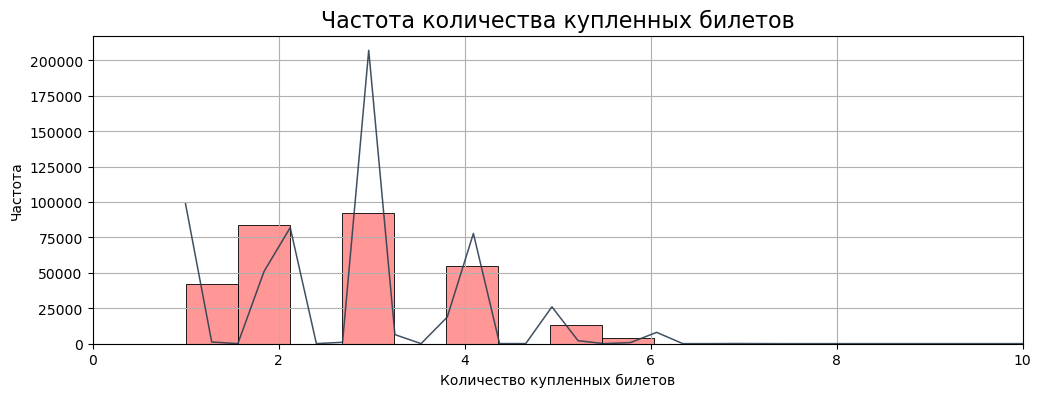

In [146]:
# Визуализация гисторграмма
sns.set_palette("husl")
def visual_hist(data, col, bins, xlab, ylab, tit, xlimit=False):
    plt.figure(figsize=(12, 4))
    res = sns.histplot(data[col], 
                 bins=bins, 
                 kde=True, 
                 color='#ff6b6b',
                 alpha=0.7,
                 cbar='r',)
    res.lines[0].set_color('#2c3e50')
    res.lines[0].set_linewidth(1.1)
    res.lines[0].set_alpha(0.9)
    
    if xlimit:
        plt.xlim(xlimit)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit, fontsize=16)
    plt.grid(True)
    plt.show()

visual_hist(data=df, 
            col='tickets_count', 
            bins=100, 
            xlimit=[0, 10],
            xlab='Количество купленных билетов',
            ylab='Частота',
            tit='Частота количества купленных билетов')

**Краткий вывод:** Визуализация показывает, что клиенты за раз больше купить между 1-4 билеты. Больше частота — 3 билеты. Хвост тянется вправо, может рассмотрим вариант скидка при покупке больше 3 или 4 билета?


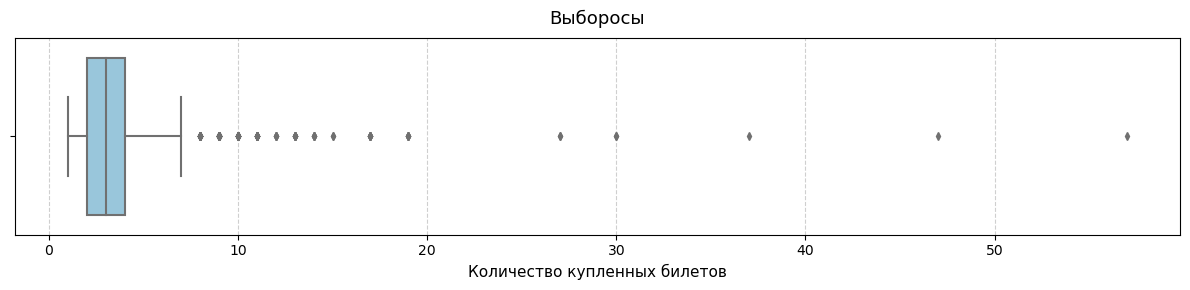

In [147]:
# Ящик с усами
def visual_box(data, col, xlab, tit, xlim=None):
    plt.figure(figsize=(12, 3))
    
    sns.boxplot(
        x=data[col],
        orient='h',
        color='#8ecae6',
        linewidth=1.5,
        fliersize=4
    )
    
    if xlim:
        plt.xlim(xlim)
        
    plt.xlabel(xlab, fontsize=11)
    plt.title(tit, fontsize=13, pad=10)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

visual_box(data=df,
          col='tickets_count',
          xlab='Количество купленных билетов',
          tit='Выборосы')

**Краткий вывод:** Больше всего данные находятся в диапазоне `от 1 до 7`. Остальные может быть, купили для корпоратив или для компанию, будем проверять по данным.

In [148]:
df.loc[df['tickets_count'] > 4, 'tickets_count'].value_counts()

5     13476
6      4283
7        62
9        38
8        21
10       19
11       13
13        7
17        6
19        5
14        4
12        4
30        2
27        2
15        2
47        1
37        1
57        1
Name: tickets_count, dtype: int64

In [149]:
# Относительное значение купленных билетов за раз до 6шт
df.loc[df['tickets_count'] < 7, 'tickets_count'].value_counts(normalize=True)

3    0.317630
2    0.288569
4    0.188732
1    0.143921
5    0.046401
6    0.014747
Name: tickets_count, dtype: float64

**Вывод:** Количество купленных билетов больше всего находятся между диапаозоном `1 и 6`. Больше всего, клиенты за раз купить `3` билеты. Так же встречаюстя большие количество купленных билетов, люди, которые за раз приобрели больше `6` билетов очень редко. Нужно больше сфокусироваться на количество между `2 и 5`, предлагать клиетнтом скидку в случае покупка большее `3 или 4` билета, чтобы увелечить верятность купить большое количество билетов за раз.

---

Столбец: `revenue_rub`, нам известно, что несколько строка пустые, так как мы перевели другую валюту. Чтобы заполнять пропуски мы дублируем данные из столбца: `revenue` с валютой: `rub` так мы заполним пропуски и пропуски не будет мешать, чтобы работат.

In [150]:
# Заполнение пропуски и проверька
print(f"До количество пропуски: {df['revenue_rub'].isna().sum()}")
df['revenue_rub'] = df['revenue_rub'].fillna(df.loc[df['currency_code'] == 'rub', 'revenue'])
print(f"После количество пропуски: {df['revenue_rub'].isna().sum()}")

До количество пропуски: 285542
После количество пропуски: 0


In [151]:
# Описательная статистика
df['revenue_rub'].describe()

count    290611.000000
mean        555.572021
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

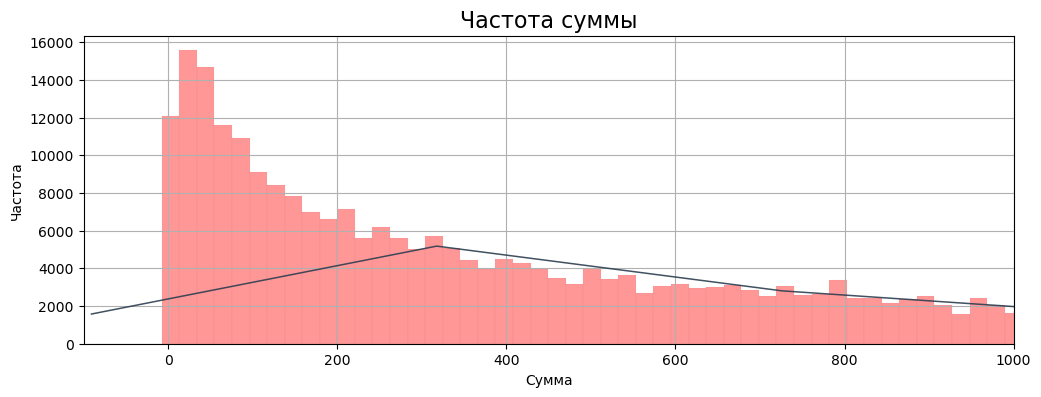

In [152]:
# Визуализация гистограмма
visual_hist(
    data=df,
    col='revenue_rub',
    bins='auto',
    xlimit=[-100, 1000],
    xlab='Сумма',
    ylab='Частота',
    tit='Частота суммы'
)

**Краткий вывод:** По картинку видно, что хвост идет вправо. Больше частота сумма до `400 рублей`, но плотность находится между диапазоном `300-320`.

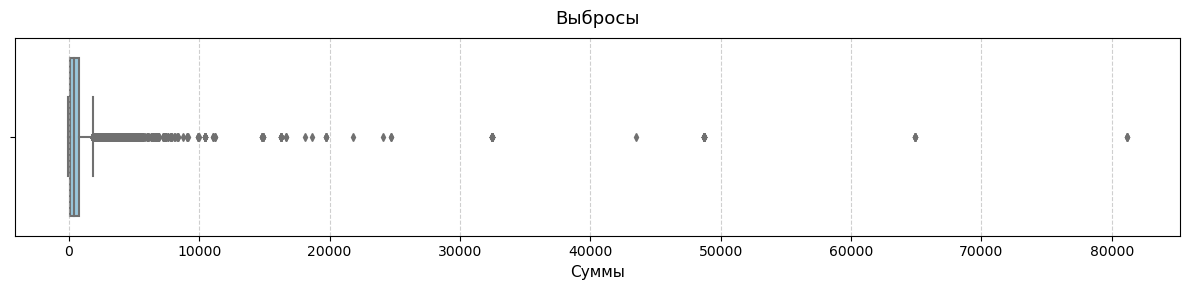

In [153]:
# Визуализация выбросов
visual_box(
    data=df,
    col='revenue_rub',
    xlab='Суммы',
    tit='Выбросы'
)

**Краткий вывод:** Суммы в основном находятся в диапазоне от `0 — 20.000`, также есть суммы с большими цифрами до чуть больше `80.000`. Проверим `0,99` процентиль и отфильтруем данные.

In [154]:
# Фильтр
old_df = df.shape
print(f"Размер датасета до: {old_df[0]}")

df = df[df['revenue_rub'] < df['revenue_rub'].quantile(0.99)]

print(f"Размер датасета после: {df.shape[0]}")
print(f"\nКолисечтво удаленных строки: {old_df[0] - df.shape[0]}")
print(f"Относительное значение: {round((old_df[0] - df.shape[0]) / old_df[0] * 100, 2)}%")

Размер датасета до: 290611
Размер датасета после: 287604

Колисечтво удаленных строки: 3007
Относительное значение: 1.03%


In [155]:
# Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287604 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287604 non-null  object        
 1   device_type_canonical  287604 non-null  object        
 2   order_id               287604 non-null  int32         
 3   order_dt               287604 non-null  datetime64[ns]
 4   order_ts               287604 non-null  datetime64[ns]
 5   currency_code          287604 non-null  object        
 6   revenue                287604 non-null  float32       
 7   tickets_count          287604 non-null  int8          
 8   days_since_prev        265889 non-null  float32       
 9   event_id               287604 non-null  int32         
 10  event_name             287604 non-null  object        
 11  event_type_main        287604 non-null  object        
 12  service_name           287604 non-null  obje

**Краткий вывод:** Мы отфильтровали данные из столбца: `revenue_rub` на `0.99` перцентилю. Так мы удалили `2 817` строки, это `1%` доля от общего количество строки.

---

### **Общий вывод по предобработке:**<br>
- Все названия столбцов приведены к единому стилю и содержат данные, соответствующие их названиям;
- Оптимизировали типы данных столбцов:
    - Столбец: `order_id` —> `int32`;
    - Столбец: `revenue` —> `float32`;
    - Столбец: `tickets_count` —> `int8`;
    - Столбец: `days_since_prev` —> `float32`;
    - Столбец: `event_id` —> `int32`;
- Отсутствуют `пропуски`, кроме столбец `days_since_prev`, это допустимо;
- Все категориальные столбцы содержит уникальные значений, `явные дубликаты` не обнаружена, так же по строкам нет дубликаты;
- Данные по выручке были приведены к единой валюте — `рублей`. Значения выручки были сохранены в новом столбец `revenue_rub`;
- Провели анализ по стлобцом: `ticktes_count` и `revenue_rub`:
    - Столбец: `tickets_count` — Клиенты часто купят `3 билеты` за раз. Так же встретились аномальные значения до `57`. Клиенты больше всего купить билеты между `1 и 6`,  нужно больше сфокусироваться на диапазон `2 и 4`, относительное значение в этом диапазоне больше. Больше `6` и выше купленных билетов за раз очень редко, возможно купили на компанию, корпоратив и т.п. Может теститруем, при покупке больше `4` или `5` билетов скидочку, это как-то влияет ли на лояльность клиентов и по выручку и как он будет часто купит билеты если действуют скидки;
    - Столбец: `revenue_rub` — Выручка, больше частота находиться в диапазоне до `400 рублей`. Встретились аномальные значений `от 20.000 до 80.000 рублей`. Отфильтровали данные по выручкам в процентиле `0.99`, `2817` — строки были удалена, это `1%` доля от общего количество;
    
---

# 3.  Создание профиля пользователя
### 3.1 Агрегированние признаки 1-го заказа для каждого пользователя.
Для каждого пользователя: 
- дата 1-го и последнего заказ; 
- устройство, с которого было сделан первый заказ; 
- регион, в котором был сделан первый заказ; 
- билетного партнёра, к которому обращались при первом заказе; 
- жанр первого посещённого мероприятия; 
- общее количество заказов; 
- средняя выручка с одного заказа в рублях; 
- среднее количество билетов в заказе; 
- среднее время между заказами;

In [156]:
df['order_id'].duplicated().sum()

0

In [157]:
# Агрегация
df_copy = df.copy()
df_copy = df_copy.sort_values(by='order_dt')

agg_users = df_copy.groupby(['user_id']).agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_order_device=('device_type_canonical', 'first'),
    first_order_region=('region_name', 'first'),
    first_order_service=('service_name', 'first'),
    first_order_event_type=('event_type_main', 'first'),
    cnt_orders=('order_id', 'count'),
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()

agg_users['avg_rev_per_order'] = agg_users['total_revenue'] / agg_users['cnt_orders']
agg_users['avg_cnt_tick_per_ord'] = agg_users['total_tickets'] / agg_users['cnt_orders']
agg_users['avg_dt_order'] = (agg_users['last_order_dt'] - agg_users['first_order_dt']) / agg_users['cnt_orders']
print(agg_users.shape)
agg_users.head()

(21848, 13)


,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,1521.939941,4.000000,0 days 00:00:00
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,917.830017,4.000000,0 days 00:00:00
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00


Добавлено нужные агрегаций для каждого пользователя, у нас общий количество пользователий — `21,848`. <br>
Теперь добавим 2 новых бинарных столбцов: 
- `is_two` — совершил ли пользователь 2 и более заказа; 
- `is_five` — совершил ли пользователь 5 и более заказов;

In [158]:
# Добавления новых столбцов
agg_users['is_two'] = ((agg_users['cnt_orders'] >= 2))
agg_users['is_five'] = (agg_users['cnt_orders'] >= 5)
agg_users.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,1521.939941,4.000000,0 days 00:00:00,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,917.830017,4.000000,0 days 00:00:00,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00,True,False


**В итоге:** <br>
Добавлен новый 2 бинарный столбец
1. `is_two` — бинарный признак, если пользователь совершил `2` и более заказа — `True`, иначе `False`. 
2. `is_five` —бинарный признак, если пользователь совершил `5` и более заказа — `True`, иначе `False`.

---

### 3.2 Провести анализ на аномалий.

Рассчитаем следующие данные:
- Общее число пользователей в выборке;
- Среднюю выручку с одного заказа;
- Долю пользователей, совершивших 2 и более заказа;
- Долю пользователей, совершивших 5 и более заказов.

In [159]:
# Считаем данные
def info_users(data):
    cnt_users = data.shape[0]
    avg_sum_per_ord = data['total_revenue'].sum() / data['cnt_orders'].sum()
    share_is_two = round(data['is_two'].mean(), 3)
    share_is_five = round(data['is_five'].mean(), 3)
    
    new_df = pd.DataFrame({'Информация':['Общее число пользователей'
                                         , 'Среднюю выручку с одного заказа'
                                         , 'Долю пользователей, совершивших 2 и более заказа'
                                         , 'Долю пользователей, совершивших 5 и более заказов'],
                          'Значение': [cnt_users
                                       , avg_sum_per_ord
                                       , share_is_two
                                       , share_is_five]}
                         ).set_index('Информация')
    return new_df

info_users(agg_users)

,Значение
Информация,
Общее число пользователей,21848.000000
Среднюю выручку с одного заказа,516.693732
"Долю пользователей, совершивших 2 и более заказа",0.617000
"Долю пользователей, совершивших 5 и более заказов",0.290000


Статистика показывает у нас есть общее `21.848` пользователей из них больше `60%` пользователей купили хотя бы как минимум `2` раза купили билеты, **`не относится покупку билетов за раз!`**. Средняя выручка с одного заказа — `516 рублей`.<br>

Следующий изучим статитческие показатели:
- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

In [160]:
# Общее клв заказов
agg_users['cnt_orders'].describe()

count    21848.000000
mean        13.163859
std        121.624128
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10175.000000
Name: cnt_orders, dtype: float64

In [161]:
# Доля
agg_users['cnt_orders'].value_counts(normalize=True)

1      0.382873
2      0.163447
3      0.099597
4      0.064033
5      0.044489
         ...   
360    0.000046
312    0.000046
248    0.000046
216    0.000046
983    0.000046
Name: cnt_orders, Length: 326, dtype: float64

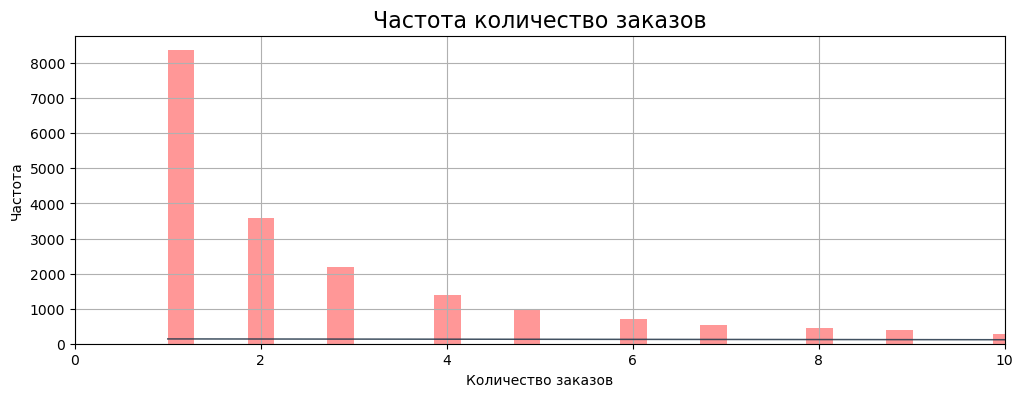

In [162]:
# Визаулизация
visual_hist(data=agg_users
           , col='cnt_orders'
           , bins='auto'
           , xlab='Количество заказов'
           , ylab='Частота'
           , tit='Частота количество заказов'
           , xlimit=[0, 10])

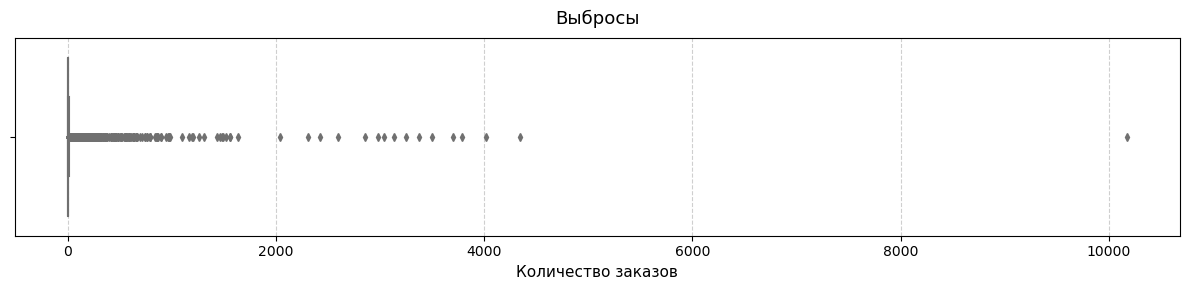

In [163]:
visual_box(data=agg_users
          , col='cnt_orders'
          , xlab='Количество заказов'
          , tit='Выбросы')

In [164]:
agg_users.loc[agg_users['cnt_orders'] > 5, 'cnt_orders'].value_counts()

6       701
7       542
8       454
9       382
10      290
       ... 
1493      1
1265      1
3136      1
3036      1
4020      1
Name: cnt_orders, Length: 321, dtype: int64

In [165]:
for i in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]:
    print(f"Процентил: {i}%, Значение: {agg_users['cnt_orders'].quantile(i)}")

Процентил: 0.5%, Значение: 2.0
Процентил: 0.6%, Значение: 3.0
Процентил: 0.7%, Значение: 4.0
Процентил: 0.8%, Значение: 7.0
Процентил: 0.85%, Значение: 10.0
Процентил: 0.9%, Значение: 15.0
Процентил: 0.95%, Значение: 31.649999999997817
Процентил: 1%, Значение: 10175.0


Опистаельная статитика и графики показывают, что у нас есть аномалия, есть цифры `10.175` — это максимальное значение, в то же время `90%` данные находятся в диапозоне от `1 до 15`. `Среднее значение` сильно отклонятся от `медиана`. Нам нужно иследовать анализ лоялность пользователей, сответственно мы будем удалять данные выше от процентил: 0.9, так как это понятно, что они активно пользуюстя сервисом.

In [166]:
# Удаление данные
q90 = agg_users['cnt_orders'].quantile(0.9)
curr_sh = agg_users.shape[0]

print(f"Размер датасета пользователей до: {curr_sh}")
agg_users = agg_users[agg_users['cnt_orders'] <= q90]
new_sh = agg_users.shape[0]
print(f"Размер датасета пользователей после: {new_sh}")
print(f"""
Абсолютное значение удаленных строков: {curr_sh - new_sh}
Относительное значение: {round(100 - (new_sh / curr_sh * 100), 2)}%
""")

Размер датасета пользователей до: 21848
Размер датасета пользователей после: 19714

Абсолютное значение удаленных строков: 2134
Относительное значение: 9.77%



In [167]:
# Статистика
agg_users['cnt_orders'].describe()

count    19714.000000
mean         3.114842
std          3.014229
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         15.000000
Name: cnt_orders, dtype: float64

**В итоге:** Удалили `2134` строки (`~10%` от общего строки), так как они имели `аномальные значений`, нам нужно работать с пользователеми, которые редко покупают билеты, чтобы понять тенденцию. В текущим датасета `среднее значение` и `медиана` отличаются на `1` больше цифр.  

---

По среднему числу билетов в заказе — выводим статистика. 

In [168]:
# Статистика
agg_users['avg_cnt_tick_per_ord'].describe()

count    19714.000000
mean         2.743291
std          0.954289
min          1.000000
25%          2.000000
50%          2.750000
75%          3.200000
max         11.000000
Name: avg_cnt_tick_per_ord, dtype: float64

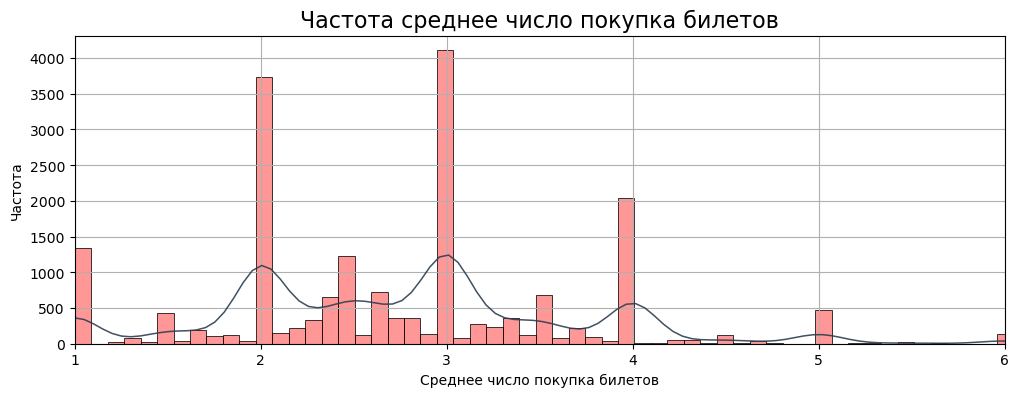

In [169]:
# Визуализация
visual_hist(data=agg_users
           , col='avg_cnt_tick_per_ord'
           , bins='auto'
           , xlab='Среднее число покупка билетов'
           , ylab='Частота'
           , tit='Частота среднее число покупка билетов'
           , xlimit=[1, 6])

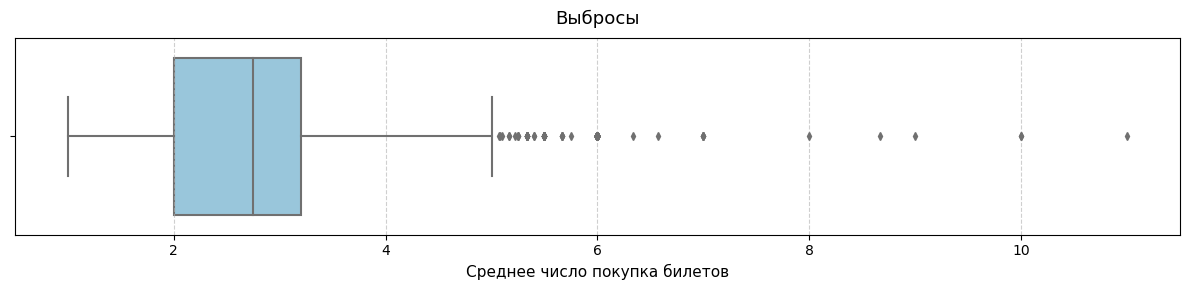

In [170]:
visual_box(data=agg_users
          , col='avg_cnt_tick_per_ord'
          , xlab='Среднее число покупка билетов'
          , tit='Выбросы')

Графики и статистика показывают не сильно отличающий цифры от друг-друга. Так же гистограмма показывает, что больше плотность находится между `1 и 4`. `Медиана` и `среднее значение` показывает 1 цифр — почти `3`. В итоге: оставим все данные как есть, так как нет никаке аномалий.

---

Следеующий  анализ — по среднему количеству дней между покупками. У нас есть пользователи **с 1 заказом**, исключим их в этом анализе, так у них среднее значение будет — `0`.

In [171]:
# Копия датасета
agg_users_copy = agg_users.copy()

# Убираем пользователей с 1 заказом
agg_users_copy = agg_users_copy[agg_users_copy['cnt_orders'] > 1]
agg_users_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11349 entries, 1 to 21844
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   user_id                 11349 non-null  object         
 1   first_order_dt          11349 non-null  datetime64[ns] 
 2   last_order_dt           11349 non-null  datetime64[ns] 
 3   first_order_device      11349 non-null  object         
 4   first_order_region      11349 non-null  object         
 5   first_order_service     11349 non-null  object         
 6   first_order_event_type  11349 non-null  object         
 7   cnt_orders              11349 non-null  int64          
 8   total_revenue           11349 non-null  float32        
 9   total_tickets           11349 non-null  float64        
 10  avg_rev_per_order       11349 non-null  float64        
 11  avg_cnt_tick_per_ord    11349 non-null  float64        
 12  avg_dt_order            11349 no

Удалили данные с 1 заказом, следующий будем извлекать день из дата.

In [172]:
agg_users_copy['day'] = agg_users_copy['avg_dt_order'].dt.days
agg_users_copy.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five,day
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00,True,False,37
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00,True,False,34
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00,True,False,8
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,15285.510742,43.0,1175.808519,3.307692,0 days 01:50:46.153846153,True,True,0
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,705.890015,3.0,352.945007,1.500000,0 days 00:00:00,True,False,0


In [173]:
# Статистика
agg_users_copy['day'].describe()

count    11349.000000
mean        11.544629
std         12.930683
min          0.000000
25%          0.000000
50%          9.000000
75%         17.000000
max         74.000000
Name: day, dtype: float64

In [174]:
# Абсолютное значение
agg_users_copy['day'].value_counts(normalize=True)

0     0.275355
9     0.038417
10    0.036743
11    0.034805
8     0.032161
        ...   
73    0.000352
68    0.000264
74    0.000264
72    0.000176
70    0.000088
Name: day, Length: 75, dtype: float64

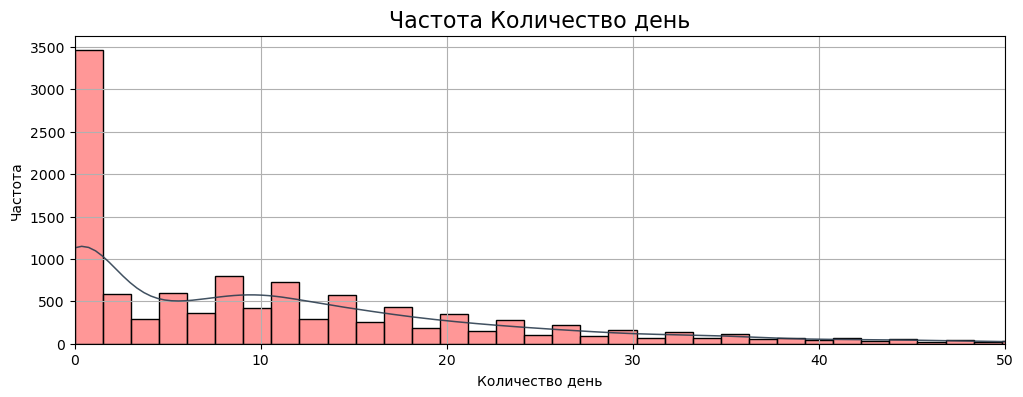

In [175]:
# Визуализация
visual_hist(data=agg_users_copy
           , col='day'
           , bins='auto'
           , xlab='Количество день'
           , ylab='Частота'
           , tit='Частота Количество день'
           , xlimit=[0, 50])

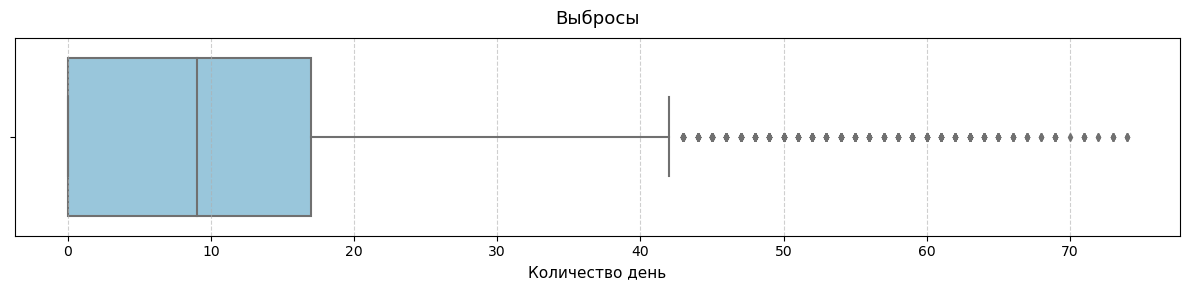

In [176]:
visual_box(data=agg_users_copy
          , col='day'
          , xlab='Количество день'
          , tit='Выбросы')

Нет сильные аномалий, оставим все данные как есть. Нам понадобиться все данные в этом случае, чтобы разобраться почему клиенты решили еще раз купить билеты через какой-то день, что их удерживали или наоборот. Так же `30%` пользователи купили свой `1 и последний билет` в `1 день` и больше не возвращились. Оставим этих данных.

---

**Общий вывод**<br>
Для каждого пользователя создано агрегированние признаки с 1 и последним заказом. Такие как:
- дата 1-го и последнего заказ; 
- устройство, с которого было сделан первый заказ; 
- регион, в котором был сделан первый заказ; 
- билетного партнёра, к которому обращались при первом заказе; 
- жанр первого посещённого мероприятия; 
- общее количество заказов; 
- общая выручка от пользователя;
- количество купленный билет за все время;
- средняя выручка с одного заказа в рублях; 
- среднее количество билетов в заказе; 
- среднее время между заказами; 

После собранный агрегированный информаций добавили новый `2` столбец: `is_two` и `is_five` где содержит бинарный признак. `is_two`— `True` если у пользователя `2` или более заказа есть иначе `False`. `is_five` — аналогично, но только больше `5` или более заказа. 

Дополнительно рассчитали следующий информаций:
- **`Общее число пользователей в выборке`** — `21.848`;
- **`Среднюю выручку с одного заказа`** — `~517 рублей`;
- **`Долю пользователей, совершивших 2 и более заказа`** — `61%`;
- **`Долю пользователей, совершивших 5 и более заказов`** — `29%`.

Анализ статистического показателя:
- **`по общему числу заказов`** — Описательная статитика показывает, что больше значений `(~90%)` данные находятся в диапазоне `1 и 15`. `38%` пользователи совершили только `1` заказ, `2` заказа `16%` пользователи. Так же графики показывали в наличий аномалий, встретились цифры до `10.175`. Так как нам нужно узнать лоялность пользователей, мы удалили данные выше `90` процентиль, так как они активно пользуются, нам нужно изучить те кто редко пользуются или перестали пользоваться. Так мы избавились `2134` строки это `~10%` от общего.


- **`по среднему числу билетов в заказе`** — Графика и статитика показывали цифры `без аномалий`, так как мы уже удалили аномальные значений выше указано. `Гистограмма` показывает больше плотность находится между `1` и `4`, `медиана` и `среднее значение` — `3`. Максимальный цифр — `11шт`. Оставили все данные.


- **`по среднему количеству дней между заказами`** — Для этого анализа мы исключили пользователи с `1` заказом, так как с `1` заказом не можем рассчитать `средний количество день между заказами`. Так, анализ показал, что `30%` пользователей осуществили свой `1` заказ и `последний заказ` в `1` день, то есть использовали сервис только `1` раз и больше не возвращались. Среднее количество между `1` и `последний заказом` —  `7-12 дней`.  

---

# 4. Исследовательский анализ данных
### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу.

#### 4.1.1. Сгруппируем пользователей с этим значением:
- по типу их первого мероприятия;
- по типу устройства, с которого совершена первая покупка;
- по региону проведения мероприятия из первого заказа;
- по билетному оператору, продавшему билеты на первый заказ.

In [177]:
agg_users = agg_users.reset_index()

In [178]:
agg_users = agg_users.drop(columns='index')
agg_users.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,1521.939941,4.000000,0 days 00:00:00,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,917.830017,4.000000,0 days 00:00:00,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00,True,False


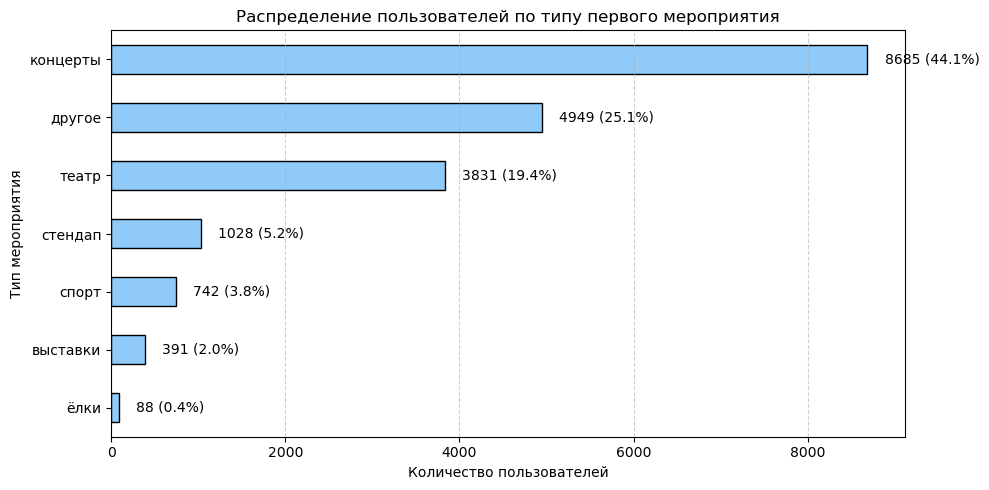

In [179]:
# Создаем функцию для визуализация
def info_first_order(data, col, xlab, ylab, tit, barh=True, top_n=False):
    if top_n:
        event = data.groupby(col).size().sort_values(ascending=False).head(top_n)
    else:
        event = data.groupby(col).size().sort_values()

    total = event.sum()

    plt.figure(figsize=(10, 5))
    
    if barh:
        ax = event.plot(kind='barh', color='#90caf9', edgecolor='k')
        
        for i, value in enumerate(event):
            plt.text(
                value + total * 0.01,
                i,
                f'{value} ({value/total:.1%})',
                va='center',
                fontsize=10
                )
    else:
        ax = event.plot(kind='bar', color='#90caf9', rot=0, width=0.2, edgecolor='k')
        
        for i, value in enumerate(event):
            plt.text(
                i,
                value + total * 0.01,
                f'{value} ({value/total:.1%})',
                ha='center',
                fontsize=10
            )

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit)

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()

# тип первого купленнего мероприятия
info_first_order(
    data=agg_users, 
    col='first_order_event_type', 
    xlab='Количество пользователей', 
    ylab='Тип мероприятия',
    tit='Распределение пользователей по типу первого мероприятия'
)

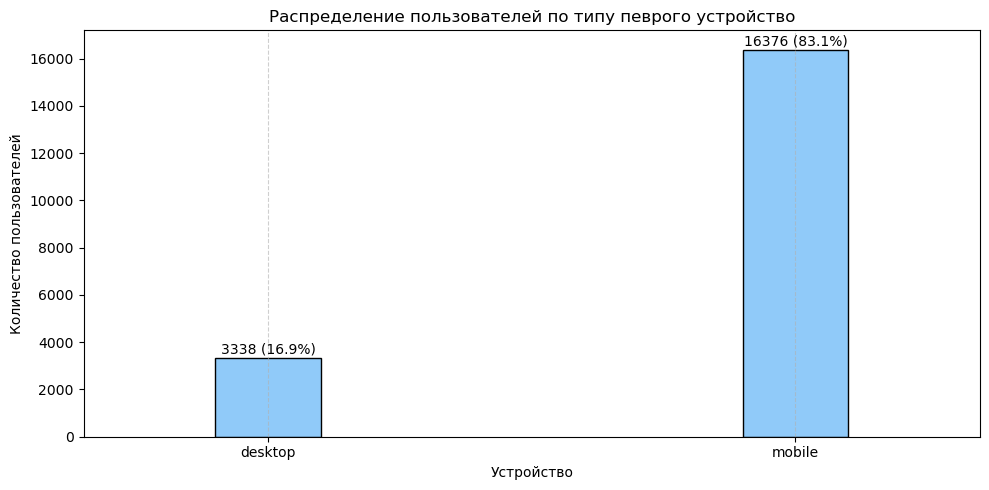

In [180]:
# Устройство
info_first_order(
    data=agg_users, 
    col='first_order_device',
    xlab='Устройство',
    ylab='Количество пользователей',
    tit='Распределение пользователей по типу певрого устройство',
    barh=False)

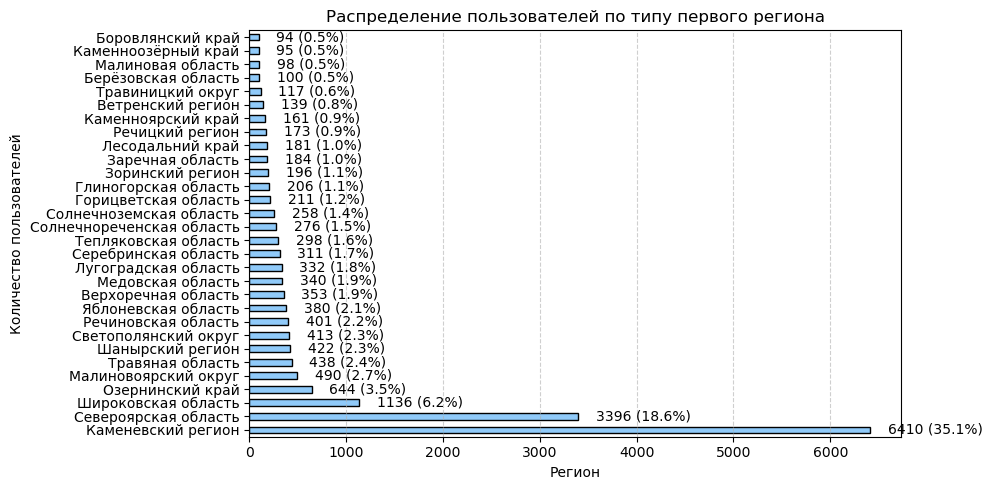

In [181]:
# Топ-30 регионы
info_first_order(
    data=agg_users,
    col='first_order_region',
    xlab='Регион',
    ylab='Количество пользователей',
    tit='Распределение пользователей по типу первого региона',
    top_n=30
)

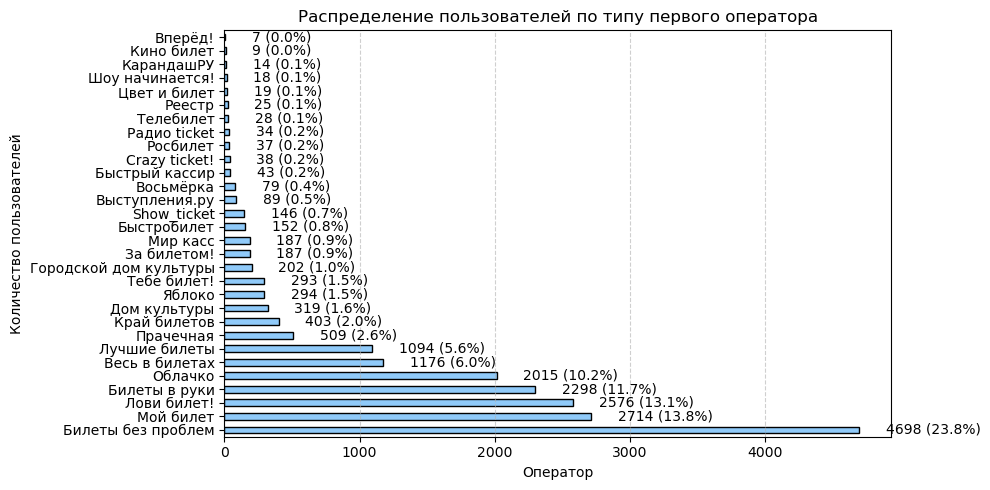

In [182]:
# Операторы
info_first_order(
    data=agg_users,
    col='first_order_service',
    xlab='Оператор',
    ylab='Количество пользователей',
    tit='Распределение пользователей по типу первого оператора',
    top_n=30
)

**Вывод:**<br>
Анализ показывал, что клиенты своих **`1-ых`** покупку купили билеты на **`концерты`**: `8694` (44.1%), `топ-2`: другое `4952` (25.1%), не относящийся к `театр, стендап и спорт.` Клиенты часто своих `1-покупку` осуществлять через `телефон`: `16379` — пользователи, это `83%`, остальные через `desktop` — `17%`.Топ-3 регионы, которые клиенты купили свой 1-й билеты: `Каменесвкий регион` — `6409` (35%), `Североярская область` — `3396` (19%) и `Широковская область` — `1139` (6%). Операторы, у кого больше клиенты с `1-ый покупкой`: `Билеты без проблем` — `4697` (24%), `Мой билет` — `2706` (14%), `Лови билет` — `2575` (13%), `Билеты в руки` — `2297` (12%) и `Облачко` — `2015` (10%), эти операторы привели в сервис больше 1-я покупка клента.

Распределение пользователей по сегментам распределено `неравномерно`. Точки входа — большее мериоприятия, который клиент купить свой 1-й билет — `концерт`, так же клиенты больше всего купить через `телефон`. По регионам так же неравномерно, зависит от  населения региона и частота мероприятия, так же нужно учитывать гости региона. 

In [183]:
df.groupby('region_name')['event_id'].size().sort_values(ascending=False)

region_name
Каменевский регион          89758
Североярская область        43758
Широковская область         16172
Медовская область           13896
Озернинский край            10405
                            ...  
Лесноярский край               19
Крутоводский регион            18
Верхозёрский край              11
Сосноводолинская область       10
Теплоозёрский округ             7
Name: event_id, Length: 81, dtype: int64

In [184]:
df.groupby('region_name')['event_id'].nunique().sort_values(ascending=False)

region_name
Каменевский регион          5940
Североярская область        3800
Широковская область         1232
Светополянский округ        1075
Речиновская область          702
                            ... 
Теплоозёрский округ            2
Сосноводолинская область       2
Верхозёрский край              2
Лесноярский край               2
Светолесский край              2
Name: event_id, Length: 81, dtype: int64

#### 4.1.2. Анализ возвраты пользователей
Долю пользователей, совершивших два и более заказа.

In [185]:
# Соберем в 1 датасет информаций
share_ord = pd.DataFrame({'total_users' : agg_users.shape[0],
                         'is_two': [agg_users['is_two'].sum()],
                          'is_two_share': [agg_users['is_two'].mean()],
                         'is_five': [agg_users['is_five'].sum()],
                        'is_five_share': [agg_users['is_five'].mean()]})

share_ord

,total_users,is_two,is_two_share,is_five,is_five_share
0,19714,11349,0.575682,4203,0.213199


<Figure size 600x400 with 0 Axes>

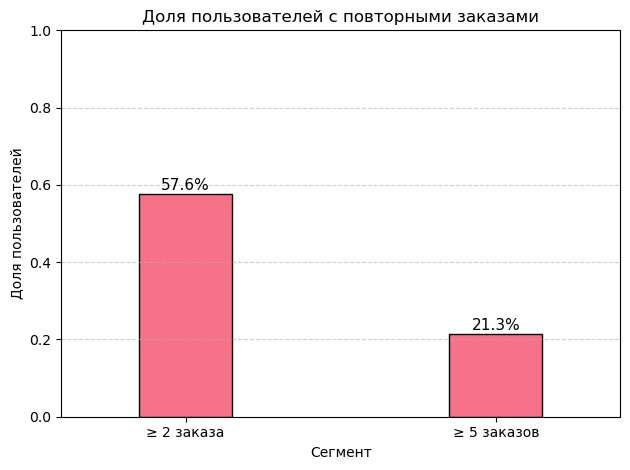

In [186]:
# Визцализация
plot_df = pd.DataFrame({
    'Сегмент': [
        '≥ 2 заказа',
        '≥ 5 заказов'
    ],
    'Доля пользователей': [
        agg_users['is_two'].mean(),
        agg_users['is_five'].mean()
    ]})

plt.figure(figsize=(6, 4))
ax = plot_df.plot(
    x='Сегмент',
    y='Доля пользователей',
    kind='bar',
    rot=0,
    width=0.3,
    edgecolor='k',
    legend=False
)

for i, value in enumerate(plot_df['Доля пользователей']):
    ax.text(
        i,
        value + 0.01,
        f'{value:.1%}',
        ha='center',
        fontsize=11
    )

plt.ylim(0, 1)
plt.ylabel('Доля пользователей')
plt.title('Доля пользователей с повторными заказами')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


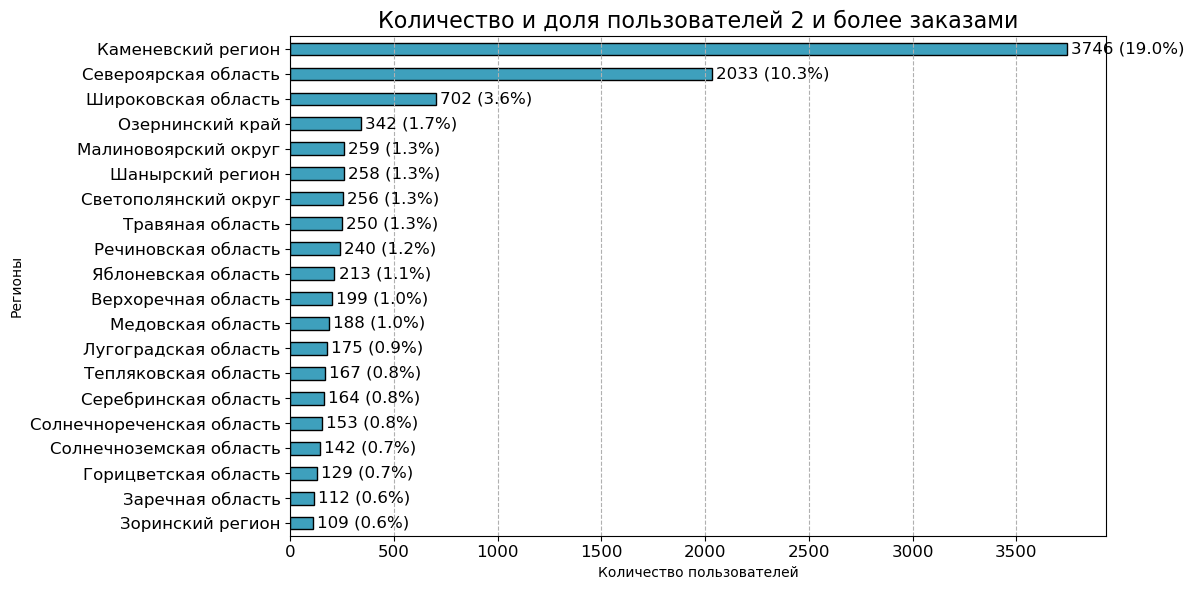

In [187]:
# Визуализация
plot_df = agg_users.groupby('first_order_region')['is_two'].sum().sort_values(ascending=True).tail(20)
plot_df = pd.DataFrame(plot_df).rename(columns={'is_two': 'cnt'})

def vis_orders_more(data, xlab, ylab, tit):
    ax = data.plot(kind='barh',
                figsize=(12,6),
                legend=False,
                color='#3EA0BD',
                     edgecolor='k')

    total = agg_users.shape[0]
    for i, val in enumerate(data['cnt']):
        plt.text(val + total * 0.001,
                i, 
                f"{val} ({val / total * 100:.1f}%)",
                va='center',
                fontsize=12)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit, fontsize=16)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(axis='x', ls='--')
    plt.tight_layout()

vis_orders_more(
    data=plot_df,
    xlab='Количество пользователей',
    ylab='Регионы',
    tit='Количество и доля пользователей 2 и более заказами'
)

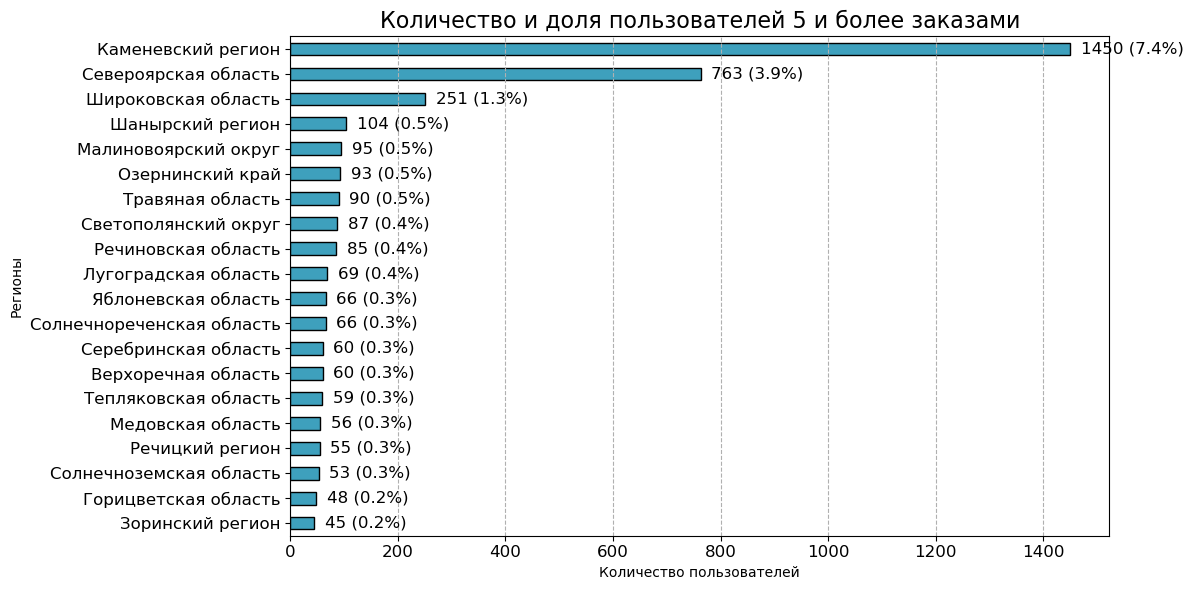

In [188]:
# Визуализация
plot_df = agg_users.groupby('first_order_region')['is_five'].sum().sort_values(ascending=True).tail(20)
plot_df = pd.DataFrame(plot_df).rename(columns={'is_five': 'cnt'})

vis_orders_more(
    data=plot_df, 
    xlab='Количество пользователей',
    ylab='Регионы',
    tit='Количество и доля пользователей 5 и более заказами')

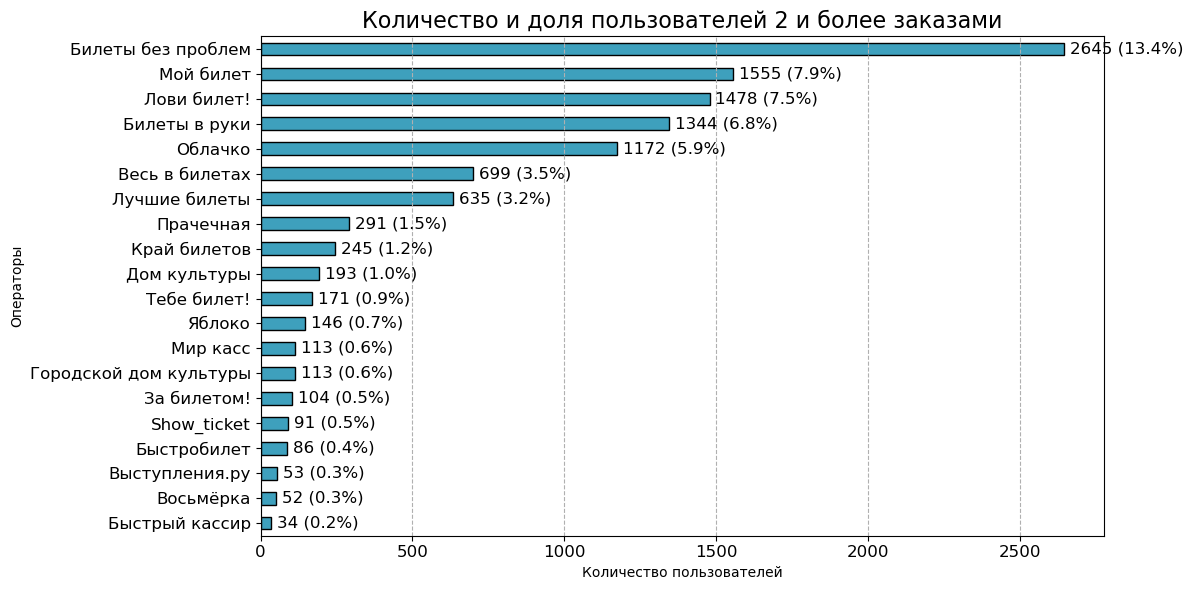

In [189]:
plot_df = agg_users.groupby('first_order_service')['is_two'].sum().sort_values(ascending=True).tail(20)
plot_df = pd.DataFrame(plot_df).rename(columns={'is_two': 'cnt'})

vis_orders_more(
    data=plot_df, 
    xlab='Количество пользователей',
    ylab='Операторы',
    tit='Количество и доля пользователей 2 и более заказами')

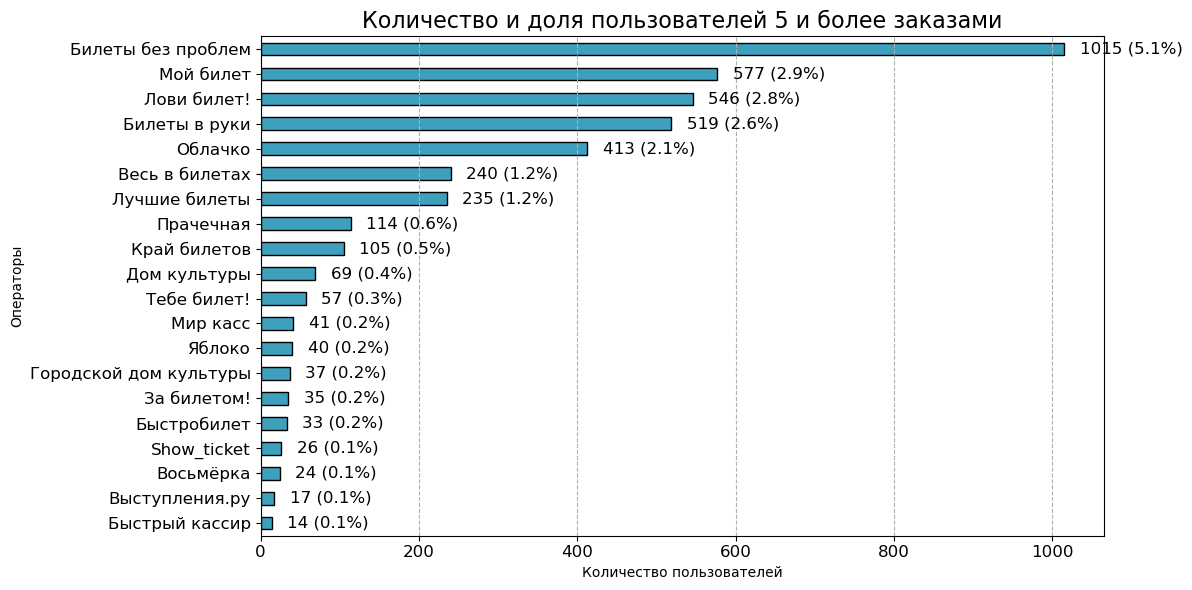

In [190]:
plot_df = agg_users.groupby('first_order_service')['is_five'].sum().sort_values(ascending=True).tail(20)
plot_df = pd.DataFrame(plot_df).rename(columns={'is_five': 'cnt'})

vis_orders_more(
    data=plot_df, 
    xlab='Количество пользователей',
    ylab='Операторы',
    tit='Количество и доля пользователей 5 и более заказами')

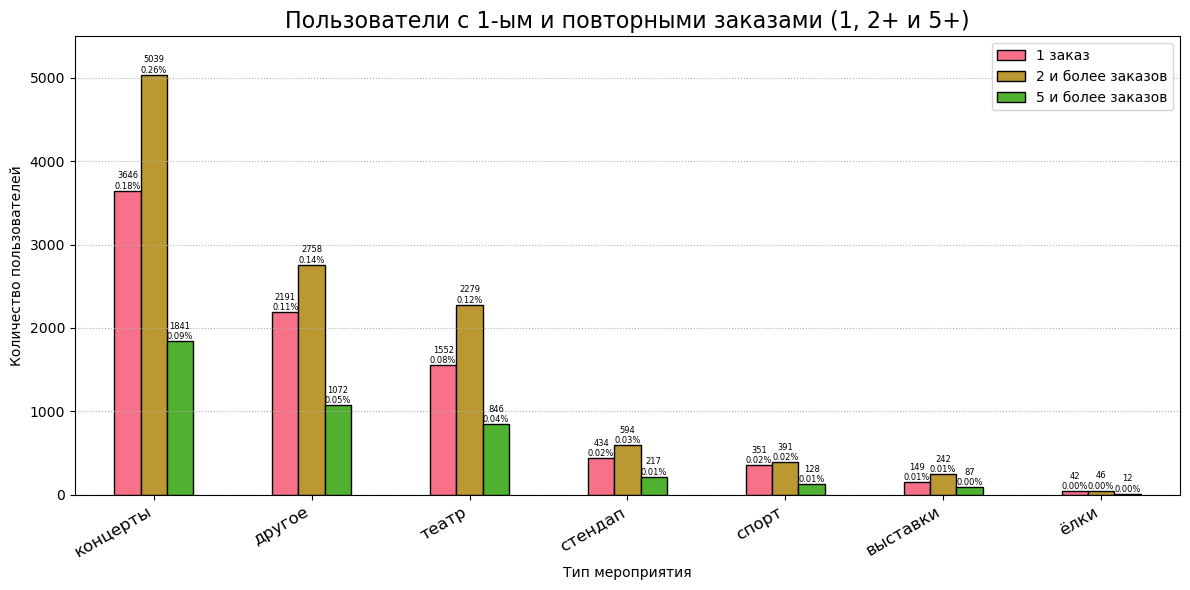

In [191]:
agg_users_copy = agg_users.copy()
agg_users_copy['is_one'] = agg_users_copy['cnt_orders'] == 1

plot_df = (
    agg_users_copy
    .groupby('first_order_event_type')
    .agg(
        one_orders=('is_one', 'sum'),
        two_orders=('is_two', 'sum'),
        five_orders=('is_five', 'sum')
    )
    .sort_values(by='one_orders', ascending=False)
)

ax = plot_df.plot(kind='bar',
            figsize=(12,6),
            edgecolor='k',
            rot=30)

total = agg_users_copy.shape[0]

for bar in ax.patches:
    height = bar.get_height()
    
    share = height / total
    
    ax.text(bar.get_x() + bar.get_width() / 2 ,
           height,
           f"{height}\n{share:.2f}%",
           ha='center',
           va='bottom',
           fontsize=6)

plt.xlabel('Тип мероприятия')
plt.ylabel('Количество пользователей')
plt.title('Пользователи с 1-ым и повторными заказами (1, 2+ и 5+)', fontsize=16)   

plt.xticks(ha='right', fontsize=12)
    
plt.ylim([0, 5500])

plt.legend(labels=['1 заказ', '2 и более заказов', '5 и более заказов'])
    
plt.grid(axis='y', ls=':')
plt.tight_layout()

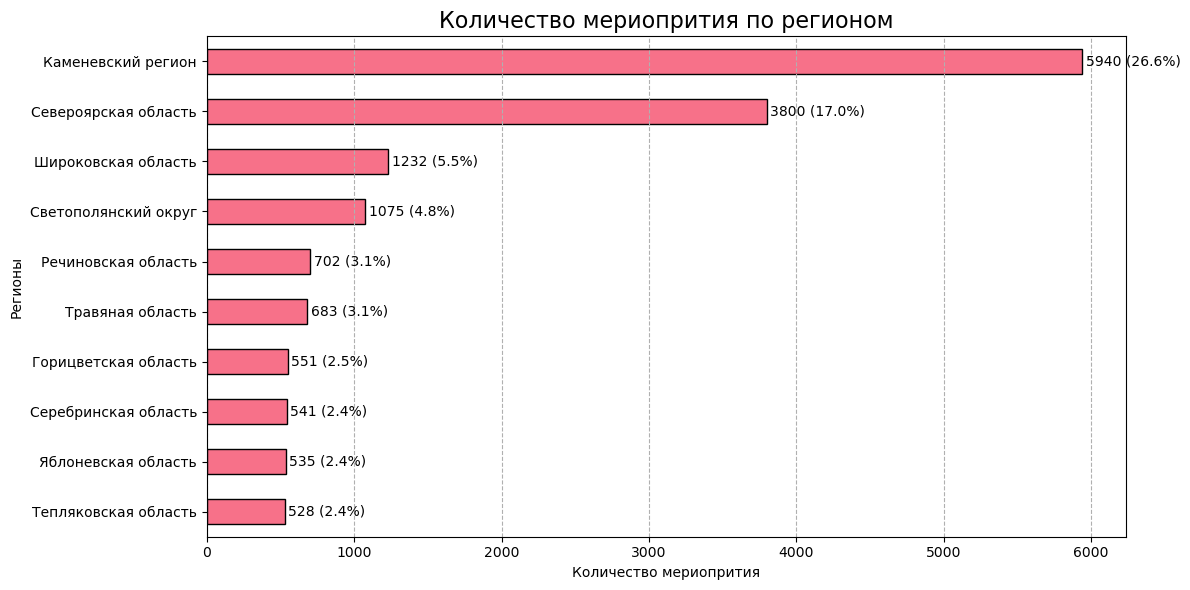

In [192]:
plot_df = df.groupby('region_name')['event_id'].nunique().sort_values().tail(10)

ax = plot_df.plot(kind='barh',
            edgecolor='k',
            figsize=(12, 6))

plt.xlabel('Количество мериопрития')
plt.ylabel('Регионы')
plt.title('Количество мериопрития по регионом', fontsize=16)

total = df['event_id'].nunique()
for i, val in enumerate(plot_df):
    ax.text(val + total * 0.001,
           i,
           f"{val} ({val / total * 100:.1f}%)",
           va='center')

plt.grid(axis='x', ls='--')
plt.tight_layout()

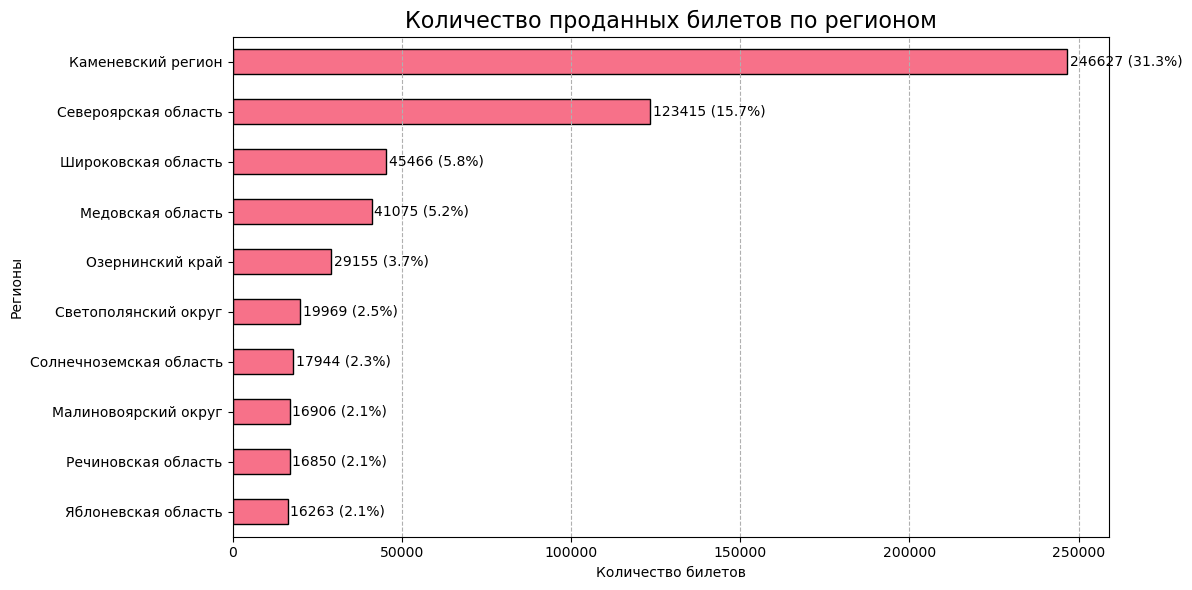

In [193]:
plot_df = df.groupby('region_name')['tickets_count'].sum().astype(int).sort_values().tail(10)

ax = plot_df.plot(kind='barh',
            edgecolor='k',
            figsize=(12, 6))

plt.xlabel('Количество билетов')
plt.ylabel('Регионы')
plt.title('Количество проданных билетов по регионом', fontsize=16)

total = df['tickets_count'].sum()
for i, val in enumerate(plot_df):
    ax.text(val + total * 0.001,
           i,
           f"{val} ({val / total * 100:.1f}%)",
           va='center')

plt.grid(axis='x', ls='--')
plt.tight_layout()

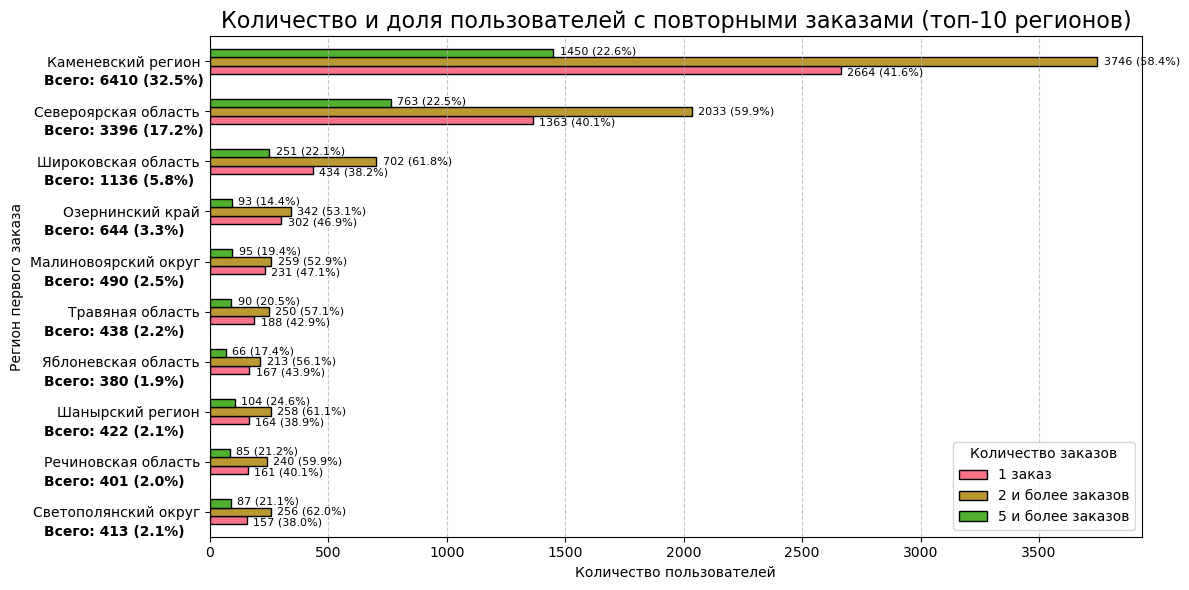

In [194]:
plot_df = agg_users_copy.groupby('first_order_region').agg(is_one=('is_one', 'sum'),
                                                          is_two=('is_two', 'sum'),
                                                          is_five=('is_five', 'sum'),
                                                           total_users=('user_id', 'size')
                                                          ).sort_values(by='is_one', ascending=True).tail(10)
plot_df['share_one'] = plot_df['is_one'] / plot_df['total_users']
plot_df['share_two'] = plot_df['is_two'] / plot_df['total_users']
plot_df['share_five'] = plot_df['is_five'] / plot_df['total_users']

ax = plot_df[['is_one', 'is_two', 'is_five']].plot(
    kind='barh',
    figsize=(12, 6),
    edgecolor='k'
)

for i, region in enumerate(plot_df.index):    
    val_one = plot_df.loc[region, 'is_one']
    share_one = plot_df.loc[region, 'share_one']
    ax.text(
        val_one + plot_df['is_one'].max() * 0.01,
        i - 0.22,
        f"{val_one} ({share_one:.1%})",
        va='center',
        fontsize=8
    )
    
    val_two = plot_df.loc[region, 'is_two']
    share_two = plot_df.loc[region, 'share_two']
    ax.text(
        val_two + plot_df['is_one'].max() * 0.01,
        i,
        f"{val_two} ({share_two:.1%})",
        va='center',
        fontsize=8
    )

    val_five = plot_df.loc[region, 'is_five']
    share_five = plot_df.loc[region, 'share_five']
    ax.text(
        val_five + plot_df['is_one'].max() * 0.01,
        i + 0.2,
        f"{val_five} ({share_five:.1%})",
        va='center',
        fontsize=8,
        color='black'
    )
    
for i, region in enumerate(plot_df.index):
    total = plot_df.loc[region, 'total_users']
    ax.text(
        -700,
        i - 0.4,
        f"Всего: {total} ({total / agg_users.shape[0] * 100:.1f}%)",
        va='center',
        fontsize=10,
        fontweight='bold'
    )

plt.xlabel('Количество пользователей')
plt.ylabel('Регион первого заказа')
plt.title('Количество и доля пользователей с повторными заказами (топ-10 регионов)', fontsize=16)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Количество заказов',
          labels=['1 заказ', '2 и более заказов', '5 и более заказов'])
plt.tight_layout()
plt.show()


**Вывод:**<br>`11974` пользователи есть, из них `57%` (11349) купили заказы `2 и более раз`. `21%` (4203) пользователи `5 и более раз` купили билеты. 

**По сегментам:**
- **Заказы 2 и более раз:**
    - **Регион:** `Каменевский регион` — 3745 `(19%)`, `Североярская область` — 2033 `(10%)` и `Широковская область` — 705 `(4%)`, в этом регионе пользователи приобрели заказ `2 и более раз`;
    - **Операторы:** `Билеты без проблем` — 2645 `(13%)`, `Мой билет` — 1544 `(8%)` и `Лови билет!` — 1481 `(7%)`, эти операторы нашли клиенты, которые купили заказы 2 и больше раз;
    - **Мериоприятия:** `Концерты` — 5022 `(25%)`, `другое` — 2775 `(14%)` и `театр` — 2282 `(12%)`, клиенты на этих меропритиях приобрели более 2 заказы. 
- **Заказы 5 и более раз:**
    - **Регион:** `Каменевский регион` — 1446 `(7%)`, `Североярская область` — 766 `(4%)` и `Широковская область` — 255 `(1%)`, клиенты в этом регионе чаще купили `5 и более` заказы;
    - **Операторы:** `Билеты без проблем` — 1016 `(5%)`, `Мой билет` — 576 `(3%)` и `Лови билет!` — 550 `(3%)`, у этих операторв больше клиенты с 5 и болнн заказами;
    - **Мериоприятия:** `Концерты` — 1836 `(9%)`, `другое` — 1079 `(5%)` и `театр` — 848 `(4%)`, клиенты купили билеты на этих меропритиях более 5 заказы.
    
Учитывая количество мериопрития по регионом, `топ-3 регионы` — `Каменевский регион`, `Североярская область` и `Широковская область`, где проходить `больше мериопрития` чем другие регионы. На этих регионах больше пользователи с `1 покупками` и `несколько покупками`. Анализ показывает, что клиенты больше увлекаются на `концерты` и на `другое(кино, шоу и т.п.)` и от сюда есть больше верятность возвращение клиентов на `15-25%`. Так же операторы: `Билеты без проблем`, `Мой билет` и `Лови билет!` — активно помогают на развития сервиса, привели клиенты, которые не пользовались с сервисом и так же больше из них возвращаются с несколькими заказами `5-20%`. 

---


**Точки вход:**
- **Регион:** `Каменевский регион`, `Североярская область` и `Широковская область` — в этом регионе больше клиенты с повторными заказами, но меньше по среднем по выборке.
- **Мериоприятия:** `Концерты`, `другое` и `театр` — так же актуально среди клиентов, есть больше верятность на повторная покупка, но меньше по среднем по выборке, кроме концерт. Концерт — есть больше верятность на 5%, что клиенты будут совершать повторная покупка.

---


**Проверька продуктовые гипотезы:** 
- **Гипотеза 1** — ответ: **нет**. Клиенты, которые купили свой 1 заказ в `спорте`, верятность больше, что не возвращаются на сервис чем на `концерты`. Разница в цифре большой: `спорт` — `2%`, `концерт` — `17%`, это цифры верятность на возврат на сервис, у кого `1 покупка спорт или концерт.` 
- **Гипотеза 2** — ответ: **нет**. Потому что, в регионе: `Каменевский регион` за `2024г`. было 5940 `(27%)` мериоприятия, `246627` количество билетов `6410` пользователи купили. `3746` из `6410`, это `58%` пользователи повторно купили билет. В тоже время в регионе `Широковская область` за `2024г`. было 1232 `(16%)`, `45466` количество билетов `1128` клиенты приобрели. `694` из `1232 (61%)` клиенты повторно купили билеты. Доля повторных заказов у всех регионов между `(53% — 61%)`, где больше пользователей в регионе, на доля повторных покупок заказов `не имеет отношение.`

---

### 4.2 Исследование поведения пользователей через показатели выручки и состава заказа
#### 4.2.1 Связь между средней выручкой и повторный заказа

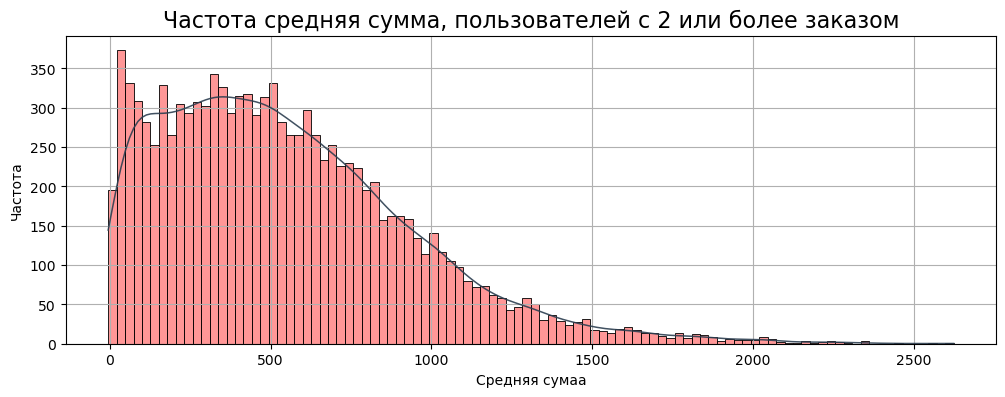

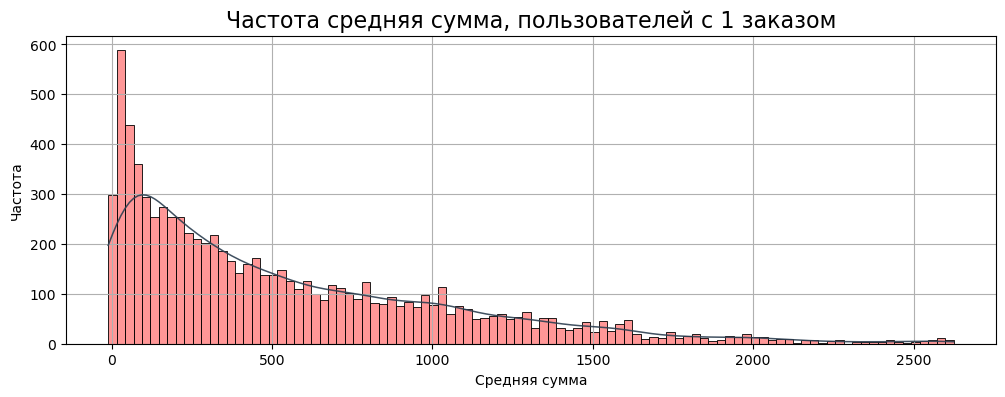

In [195]:
plot_df = agg_users_copy.loc[agg_users_copy['is_two'] == True, 'avg_rev_per_order']
plot_df = pd.DataFrame(plot_df)
visual_hist(data=plot_df,
           col='avg_rev_per_order',
           bins=100,
           xlab='Средняя сумаа',
           ylab='Частота',
           tit='Частота средняя сумма, пользователей с 2 или более заказом')

plot_df = agg_users_copy.loc[agg_users_copy['is_one'] == True, 'avg_rev_per_order']
plot_df = pd.DataFrame(plot_df)
visual_hist(data=plot_df,
           col='avg_rev_per_order',
           bins=100,
           xlab='Средняя сумма',
           ylab='Частота',
           tit='Частота средняя сумма, пользователей с 1 заказом')

**Краткий вывод:**

**1 заказ:**
- Средняя выручка находиться в диапазоне между `500-550 рублей`.
- Частота средняя сумма больше находиться между от `50-1000 рублей`.

**2 или более заказы:**
- Средняя выручка находиться в диапазоне между `500-550 рублей`.
- Частота средняя сумма больше находиться между `50-1500 рублей`.

У обех графика по сумму `нет разница`, но клиенты с `1 заказом` больше рассмотривают покупку билеты средняя сумма до `300рублей`, с `2 или более` заказами  чаще покупают билеты средняя сумма до `1000рублей`.

---

#### 4.2.2 Распределение по средней выручке с заказа в двух группах пользователей
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

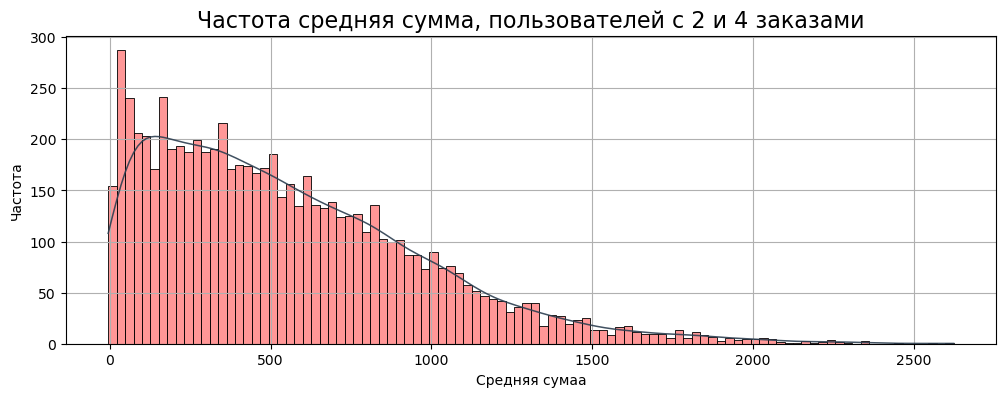

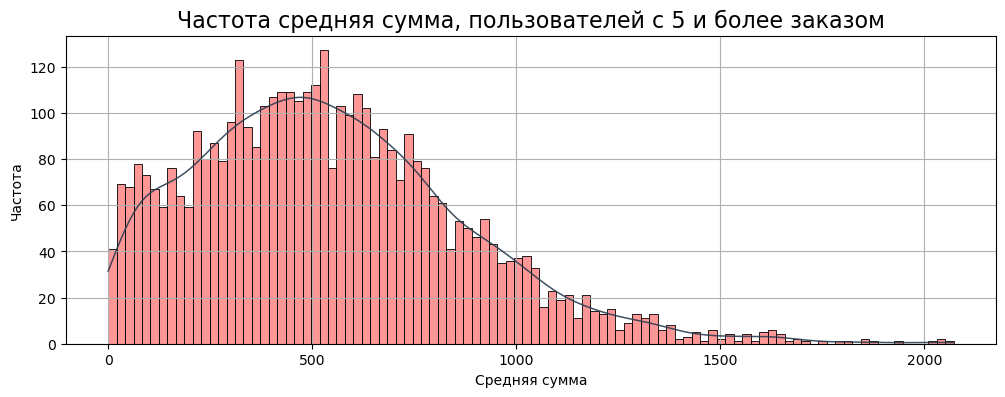

In [196]:
plot_df = agg_users_copy.loc[(agg_users_copy['cnt_orders'] >= 2) & (agg_users_copy['cnt_orders'] <= 4), 'avg_rev_per_order']
plot_df = pd.DataFrame(plot_df)
visual_hist(data=plot_df,
           col='avg_rev_per_order',
           bins=100,
           xlab='Средняя сумаа',
           ylab='Частота',
           tit='Частота средняя сумма, пользователей с 2 и 4 заказами')

plot_df = agg_users_copy.loc[agg_users_copy['cnt_orders'] >= 5, 'avg_rev_per_order']
plot_df = pd.DataFrame(plot_df)
visual_hist(data=plot_df,
           col='avg_rev_per_order',
           bins=100,
           xlab='Средняя сумма',
           ylab='Частота',
           tit='Частота средняя сумма, пользователей с 5 и более заказом')

**Краткий вывод:**

График в обоих сегментах имеют правостороннюю ассиметрию.

В обоих сегменты `средняя значения` находиться в диапазоне `550-600`. Сегмент с `2 и 4 заказами`: диапазон `50-1000 рублей` больше частота, сегмент: `более 5 заказами` также находиться в этой `диапазоне`. Кроме 1-сегменте `(2 и 4 заказ)` плотность идет внизу в то же время 2-сегмент `(5 и более заказ)` в диапазоне до `50-500` плотность увеличивается. 

---

#### 4.2.3 Анализ влияние среднего количества билетов в заказе на вероятность повторной покупки.
Распределение пользователей по среднему количеству билетов в заказе

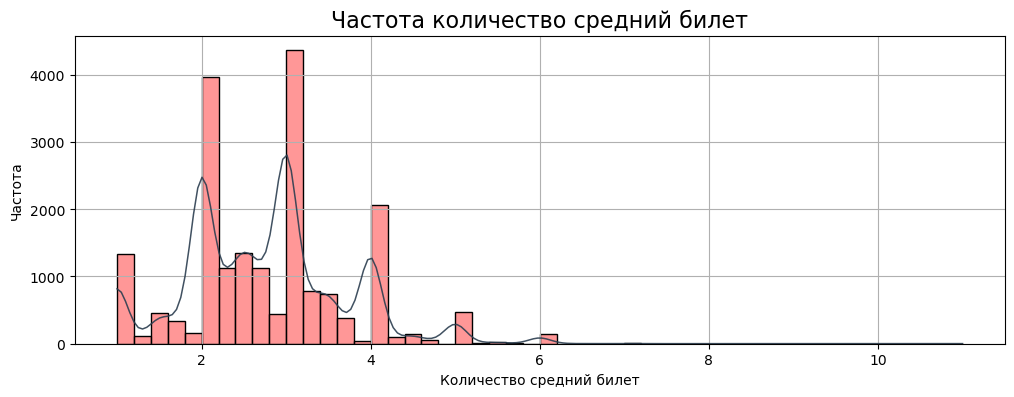

In [197]:
visual_hist(data=agg_users,
           col='avg_cnt_tick_per_ord',
           bins=50,
           xlab='Количество средний билет',
           ylab='Частота',
           tit='Частота количество средний билет'
           )

**Краткий вывод:**

Графика показывает масса наблюдений находится в диапазоне `1-5`. Так же визуализация показывает в диапазоне `2 и 4` клиенты больше сосредоточена. Встречаются большие цифры до `11`.

---

Сегментация пользователей по средному количеству билетов в заказе:
- `от 1 до 2 билетов`;
- `от 2 до 3 билетов`;
- `от 3 до 5 билетов`;
- `от 5 и более билетов`.

In [198]:
# Фильтрация 
agg_users_copy['is_one_tick'] = (agg_users_copy['avg_cnt_tick_per_ord'] >= 1) & (agg_users_copy['avg_cnt_tick_per_ord'] < 2)

agg_users_copy['is_two_tick'] = (agg_users_copy['avg_cnt_tick_per_ord'] >= 2) & (agg_users_copy['avg_cnt_tick_per_ord'] < 3)
                                          
agg_users_copy['is_three_tick'] = (agg_users_copy['avg_cnt_tick_per_ord'] >= 3) & (agg_users_copy['avg_cnt_tick_per_ord'] < 5)
                                          
agg_users_copy['is_five_tick'] = (agg_users_copy['avg_cnt_tick_per_ord'] >= 5)
                                                
agg_users_copy.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five,is_one,is_one_tick,is_two_tick,is_three_tick,is_five_tick
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,1521.939941,4.000000,0 days 00:00:00,False,False,True,False,False,True,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00,True,False,False,False,False,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00,True,False,False,False,True,False,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,917.830017,4.000000,0 days 00:00:00,False,False,True,False,False,True,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00,True,False,False,True,False,False,False


In [199]:
# Сбор информация 
segment_tic = pd.DataFrame({'Col': [
                                    'is_one_tick',
                                    'share_is_one',
                                    'is_two_tick',
                                    'share_is_two',
                                    'is_three_tick',
                                    'share_is_three',
                                    'is_five_tick',
                                    'share_is_five'],
                  'all_order': [
                      agg_users_copy['is_one_tick'].sum(),
                      agg_users_copy['is_one_tick'].mean() * 100,
                      agg_users_copy['is_two_tick'].sum(),
                      agg_users_copy['is_two_tick'].mean() * 100,
                      agg_users_copy['is_three_tick'].sum(),
                      agg_users_copy['is_three_tick'].mean() * 100,
                      agg_users_copy['is_five_tick'].sum(),
                      agg_users_copy['is_five_tick'].mean() * 100
                  ],
                   'repeat_order': [
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_one_tick'].sum(),
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_one_tick'].sum() / agg_users_copy.shape[0] * 100,
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_two_tick'].sum(),
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_two_tick'].sum() / agg_users_copy.shape[0] * 100,
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_three_tick'].sum(),
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_three_tick'].sum() / agg_users_copy.shape[0] * 100,
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_five_tick'].sum(),
                       agg_users_copy.loc[agg_users_copy['is_two'] == 1, 'is_five_tick'].sum() / agg_users_copy.shape[0] * 100,
                   ]}).set_index('Col').T

segment_tic

Col,is_one_tick,share_is_one,is_two_tick,share_is_two,is_three_tick,share_is_three,is_five_tick,share_is_five
all_order,2394.0,12.143654,8015.0,40.656386,8644.0,43.847012,661.0,3.352947
repeat_order,1216.0,6.168205,5505.0,27.924318,4504.0,22.846708,124.0,0.628995


**all_order:** — все данные включая пользователи с `1 заказами.`<br>
**repeat_order:** — включено фильтрация, пользователи с `2 и более заказами`.

(0.0, 10000.0)

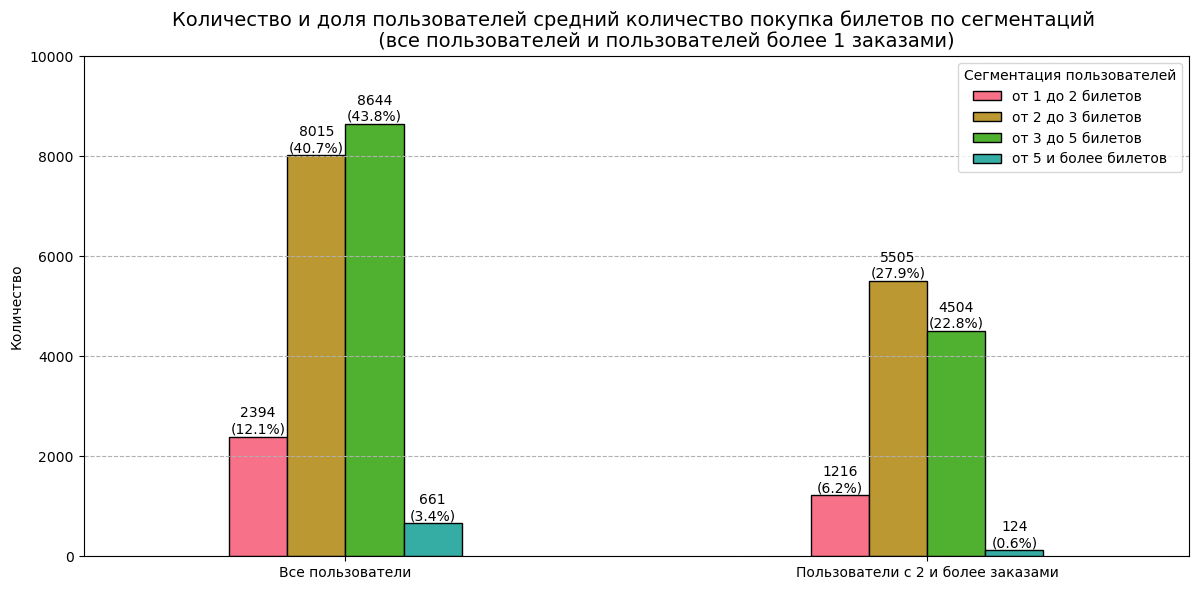

In [200]:
val = ['is_one_tick', 'is_two_tick', 'is_three_tick', 'is_five_tick']
share = ['share_is_one', 'share_is_two', 'share_is_three', 'share_is_five']

ax = segment_tic[val].plot(kind='bar',
                          rot=0,
                          figsize=(12, 6),
                          edgecolor='k',
                          width=0.4)

plt.ylabel('Количество')
plt.title('''Количество и доля пользователей средний количество покупка билетов по сегментаций 
          (все пользователей и пользователей более 1 заказами)''', 
         fontsize=14)

total = agg_users_copy.shape[0]

for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x() + i.get_width() / 2,
           height,
           f"{int(height)}\n({height / total * 100:.1f}%)",
           ha='center',
           va='bottom')

plt.xticks(ticks=[0, 1],
    labels=['Все пользователи', 'Пользователи с 2 и более заказами'])

plt.grid(axis='y', ls='--')
plt.tight_layout()

plt.legend(['от 1 до 2 билетов', 'от 2 до 3 билетов', 'от 3 до 5 билетов', 'от 5 и более билетов'], 
           title='Сегментация пользователей')

plt.ylim([0, 10000])

**Краткий вывод:**

Сегменты распределено `неравномерно`, то есть `сконцентировано`. Наблюдается `топ-2` лидеры со значением: `от 2 до 3 билетов` и `от 3 до 5 билетов`.

**Все Пользователи:**
- `значение:` **от 2 до 3 билетов** — 8015 `(41%)`, пользователи купили среднем билеты между `2 и 3`;
- `значение:` **от 3 до 5 билетов** — 8644 `(44%)`, пользователи купили среднем билеты между `3 и 5`.
<br><br>
- `аномалия:` **от 5 и более заказов** — 661 `(3.4%)`, сегмент находиться очень низко сравнивая с другими, это цифр клиенты, которые больше купили в среднем `5 или более билетов`.

**Пользователи с повторными заказми:**
- `значение:` **от 2 до 3 билетов** — 5505 `(28%)`, пользователи с `2 и более` зкакзами, купили среднем билеты между `2 и 3`;
- `значение:` **от 3 до 5 билетов** — 4504 `(23%)`, пользователи с `2 и более` зкакзами, купили среднем билеты между `3 и 5`.
<br><br>
- `аномалия:` **от 5 и более заказов** — 124 `(0.6%)`, очень низкий доля чем других. Клиенты очень мало сранивая с другими сегментами, которые повторно возвращаются и купить в среднеи `5 и более билетов`. 

---

### 4.3 Исследование временных характеристик первого заказа и их влияния на повторные покупки
Анализ временные параметры, связанные с первым заказом пользователей.

In [201]:
# День неделя
agg_users_copy['day_of_week_first_ord'] = agg_users_copy['first_order_dt'].dt.dayofweek
agg_users_copy.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,...,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five,is_one,is_one_tick,is_two_tick,is_three_tick,is_five_tick,day_of_week_first_ord
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,...,4.000000,0 days 00:00:00,False,False,True,False,False,True,False,1
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,...,3.000000,37 days 12:00:00,True,False,False,False,False,True,False,1
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,...,2.666667,34 days 00:00:00,True,False,False,False,True,False,False,5
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,...,4.000000,0 days 00:00:00,False,False,True,False,False,True,False,3
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,...,1.500000,8 days 00:00:00,True,False,False,True,False,False,False,6


In [202]:
# Лайфтайм
agg_users_copy['lifetime'] = pd.Timestamp.now() - agg_users_copy['first_order_dt']
agg_users_copy.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,...,avg_dt_order,is_two,is_five,is_one,is_one_tick,is_two_tick,is_three_tick,is_five_tick,day_of_week_first_ord,lifetime
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,...,0 days 00:00:00,False,False,True,False,False,True,False,1,513 days 00:36:09.247407
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,...,37 days 12:00:00,True,False,False,False,False,True,False,1,541 days 00:36:09.247407
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,...,34 days 00:00:00,True,False,False,False,True,False,False,5,551 days 00:36:09.247407
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,...,0 days 00:00:00,False,False,True,False,False,True,False,3,518 days 00:36:09.247407
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,...,8 days 00:00:00,True,False,False,True,False,False,False,6,473 days 00:36:09.247407


In [203]:
# Средний интервал между покупками, у кого 2 и более заказы. Формула интервала: (last_order - first_order) / (n - 1)

agg_users_copy['ival_2_ord'] = ((agg_users_copy['last_order_dt'] - agg_users_copy['first_order_dt']) / 
                                   (agg_users_copy['cnt_orders'] - 1))

mean_val_int = agg_users_copy[agg_users_copy['cnt_orders'] >= 2]
mean_val_int['ival_2_ord'].mean()

Timedelta('18 days 02:38:38.209625426')

Среднй интервал: `18 день`.

---

#### 4.3.1 Анализ день недели на покупки пользователей.

In [204]:
# Группировка
day_of_week_cnt = agg_users_copy.groupby('day_of_week_first_ord').agg(all_users=('user_id', 'size'),
                                                                       repeat_ord=('is_two', 'sum')
                                                                      )
day_of_week_cnt

,all_users,repeat_ord
day_of_week_first_ord,,
0,2652,1569
1,2843,1637
2,2820,1664
3,2904,1641
4,3031,1721
5,2960,1723
6,2504,1394


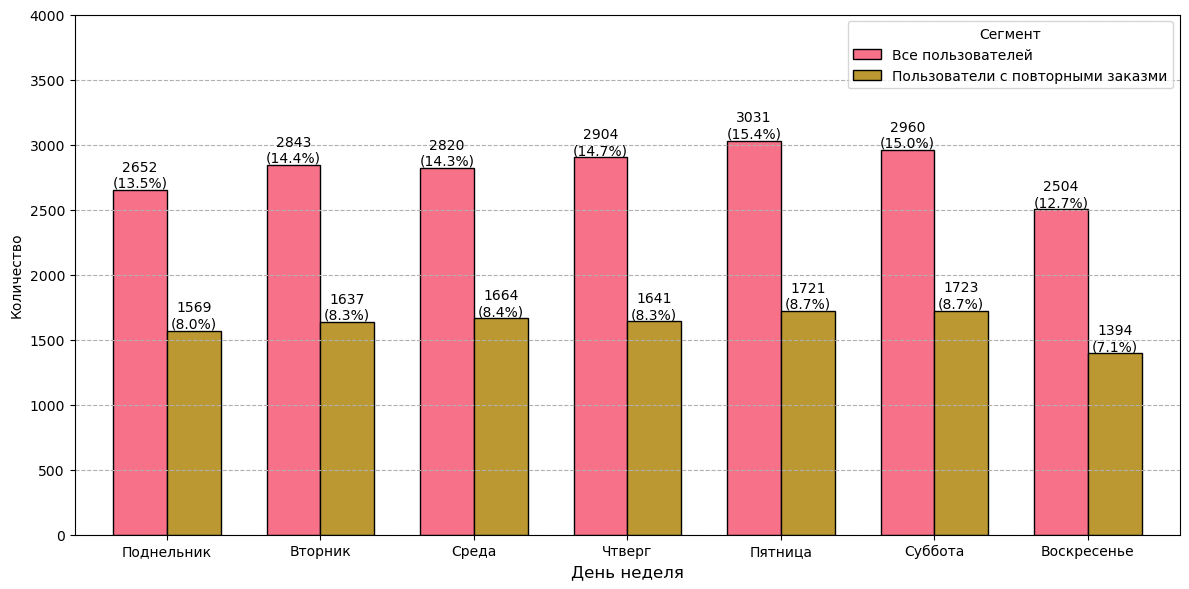

In [205]:
# Визаулизация
ax = day_of_week_cnt.plot(kind='bar',
                    figsize=(12, 6),
                    rot=0,
                    edgecolor='k',
                         width=0.7)

plt.ylabel('Количество')
plt.xlabel('День неделя', fontsize=12)

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6],
          labels=['Поднельник', 'Вторник', 'Среда',
                 'Чтверг', 'Пятница', 'Суббота', 'Воскресенье'])

for val in ax.patches:
    height = val.get_height()
    ax.text(val.get_x() + val.get_width() / 2,
           height,
           f"{height}\n({height/agg_users_copy.shape[0]*100:.1f}%)",
           ha='center',
           va='bottom'
           )

plt.ylim([0, 4000])

plt.grid(axis='y', ls='--')
plt.tight_layout()

plt.legend(labels=['Все пользователей', 'Пользователи с повторными заказми'],
          title='Сегмент',
          loc='upper right')

**Ответь на вопрос:** Графика распределено `равномерно`, обозначает, что день неделя `1-ая покупка` не влияет на возврат клиентов. Все пользователи включая с `1-покупками` в день между диапазоне `2500-3000`, это `14%` пользователи от общего. Пользователей с `2 и более покупками` находится 1400-1700 `(8%)`.

---

#### 4.3.2 Как средний интервал между заказами влияет на удержание клиентов.

In [206]:
# Извлекаем день
agg_users_copy['ival_2_ord'] = agg_users_copy['ival_2_ord'].dt.days
agg_users_copy

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,...,is_two,is_five,is_one,is_one_tick,is_two_tick,is_three_tick,is_five_tick,day_of_week_first_ord,lifetime,ival_2_ord
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,...,False,False,True,False,False,True,False,1,513 days 00:36:09.247407,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,...,True,False,False,False,False,True,False,1,541 days 00:36:09.247407,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,...,True,False,False,False,True,False,False,5,551 days 00:36:09.247407,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,...,False,False,True,False,False,True,False,3,518 days 00:36:09.247407,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,...,True,False,False,True,False,False,False,6,473 days 00:36:09.247407,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19709,ffed3ff067d4f12,2024-07-31,2024-10-17,mobile,Малиновая область,Лучшие билеты,другое,4,202.059998,9.0,...,True,False,False,False,True,False,False,2,533 days 00:36:09.247407,26.0
19710,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,6192.390137,23.0,...,True,True,False,False,True,False,False,1,548 days 00:36:09.247407,13.0
19711,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,1701.989990,5.0,...,True,False,False,False,True,False,False,3,518 days 00:36:09.247407,74.0
19712,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.530029,2.0,...,False,False,True,False,True,False,False,1,478 days 00:36:09.247407,NaN


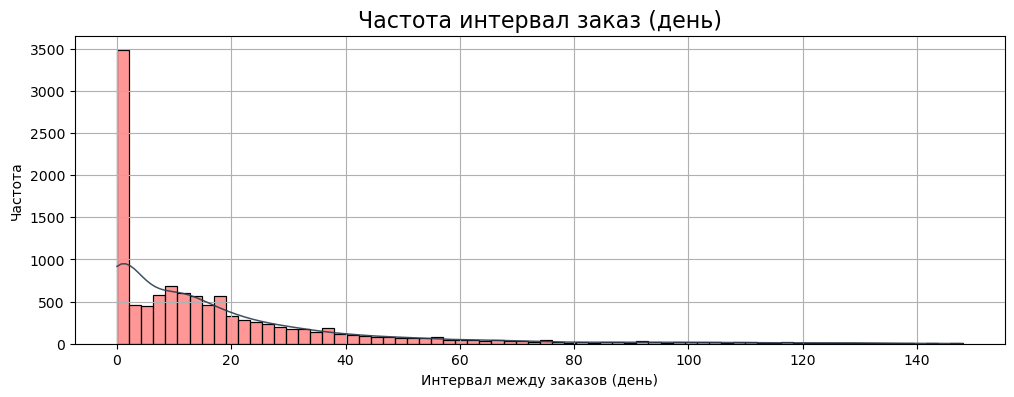

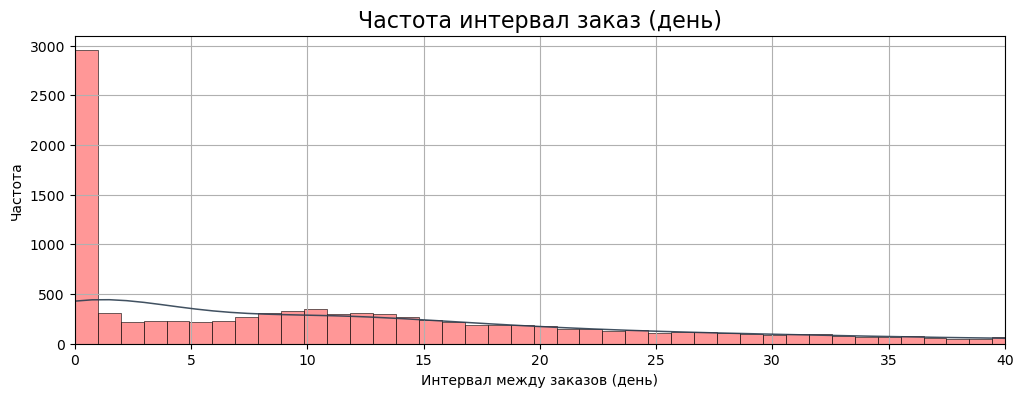

In [207]:
# Визуализация интервала
visual_hist(data=agg_users_copy,
           col='ival_2_ord',
           bins='auto',
           xlab='Интервал между заказов (день)',
           ylab='Частота',
           tit='Частота интервал заказ (день)')

visual_hist(data=agg_users_copy,
           col='ival_2_ord',
           bins=150,
           xlab='Интервал между заказов (день)',
           ylab='Частота',
           tit='Частота интервал заказ (день)',
           xlimit=[0, 40])

In [208]:
# Проверька
agg_users_copy['ival_2_ord'].value_counts(normalize=True)

0.0      0.260023
10.0     0.031104
9.0      0.029166
8.0      0.027227
12.0     0.027051
           ...   
141.0    0.000088
143.0    0.000088
136.0    0.000088
147.0    0.000088
135.0    0.000088
Name: ival_2_ord, Length: 147, dtype: float64

**Краткий вывод:** `26%` пользователей, которые совершили `2 и более заказы` совершили в `1 день`, и не возвращались на сервсис. Интервал `1-м` и `последним заказом` больше находится `от 0 до 40 дней`.

Сегментация пользователей и рассчитаем средний интервал.
- совершившие `2–4 заказа`;
- совершившие `5 и более заказов`.

In [209]:
# Сегментация пользователей
agg_users_copy['is_two_four_ord'] = (agg_users_copy['cnt_orders'] >= 2) & (agg_users_copy['cnt_orders'] < 5)

agg_users_copy.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,...,is_five,is_one,is_one_tick,is_two_tick,is_three_tick,is_five_tick,day_of_week_first_ord,lifetime,ival_2_ord,is_two_four_ord
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,...,False,True,False,False,True,False,1,513 days 00:36:09.247407,NaN,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,...,False,False,False,False,True,False,1,541 days 00:36:09.247407,75.0,True
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,...,False,False,False,True,False,False,5,551 days 00:36:09.247407,51.0,True
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,...,False,True,False,False,True,False,3,518 days 00:36:09.247407,NaN,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,...,False,False,True,False,False,False,6,473 days 00:36:09.247407,16.0,True


In [210]:
ord_two_four = agg_users_copy.loc[agg_users_copy['is_two_four_ord'] == 1, 'ival_2_ord']
mean_ord_two_four = ord_two_four.mean()

ord_five = agg_users_copy.loc[agg_users_copy['is_five'] == 1, 'ival_2_ord']
mean_ord_five = ord_five.mean()

print(f"Средний интервал совершившие 2–4 заказа: {mean_ord_two_four:.1f} день")
print(f"Средний интервал совершившие 5 и более заказов: {mean_ord_five:.1f} день")

Средний интервал совершившие 2–4 заказа: 21.3 день
Средний интервал совершившие 5 и более заказов: 12.1 день


In [211]:
agg_users_copy['ival_2_ord'].unique()

array([ nan,  75.,  51.,  16.,   0.,  43.,  27.,  29.,  20.,  18.,  19.,
        10.,   5.,   9.,  53.,  12.,  68.,  49.,  13.,   6.,   1.,  14.,
         8.,  72.,  28.,   2.,  17., 122.,  21.,   4.,   3.,  50.,  40.,
        88., 128.,  15.,  36.,  41.,   7.,  48.,  46.,  94.,  26.,  30.,
        22.,  45.,  23.,  34., 115.,  24.,  35.,  25.,  38.,  39., 112.,
        33.,  11.,  55.,  77.,  44.,  95.,  32.,  56.,  84., 129.,  86.,
        42., 100., 105.,  37.,  54., 127., 109.,  58.,  31.,  60.,  66.,
        76.,  79., 110., 148.,  90.,  61.,  59., 120.,  96., 139.,  47.,
        89.,  52.,  87., 103.,  81.,  93., 104.,  85., 116.,  67.,  78.,
        70.,  65.,  69.,  91., 124.,  97., 111.,  92.,  57., 106.,  63.,
       121., 144.,  64.,  82.,  62.,  99.,  74., 117., 134., 142.,  71.,
       114., 102.,  98.,  73., 118., 125., 141., 131., 108., 137., 133.,
        83.,  80., 132., 126., 130., 123., 138., 119., 146., 113., 136.,
       135., 107., 147., 143., 101.])

In [212]:
agg_users_copy['ival_2_ord'].describe()

count    11349.000000
mean        17.895586
std         23.615676
min          0.000000
25%          0.000000
50%         11.000000
75%         24.000000
max        148.000000
Name: ival_2_ord, dtype: float64

In [213]:
bins=[0, 3, 5, 7, 12, 24, 148]
labels=['0_3_day', '3_5_day', '5_7_day', '7_12_day', '12_24_day', '24+day']

agg_users_copy['cat_ival_day'] = pd.cut(x=agg_users_copy['ival_2_ord'],
       bins=bins,
      labels=labels)

agg_users_copy['is_three'] = agg_users_copy['cnt_orders'] >= 3

In [214]:
rate_cat_day = agg_users_copy.groupby('cat_ival_day').agg(users=('cat_ival_day', 'size'),
                                          rate=('is_three', 'mean'))
rate_cat_day = rate_cat_day.sort_values(by='rate', ascending=True)
rate_cat_day

,users,rate
cat_ival_day,,
24+day,2749,0.571117
0_3_day,755,0.705960
3_5_day,452,0.825221
5_7_day,498,0.861446
12_24_day,2345,0.876333
7_12_day,1599,0.896811


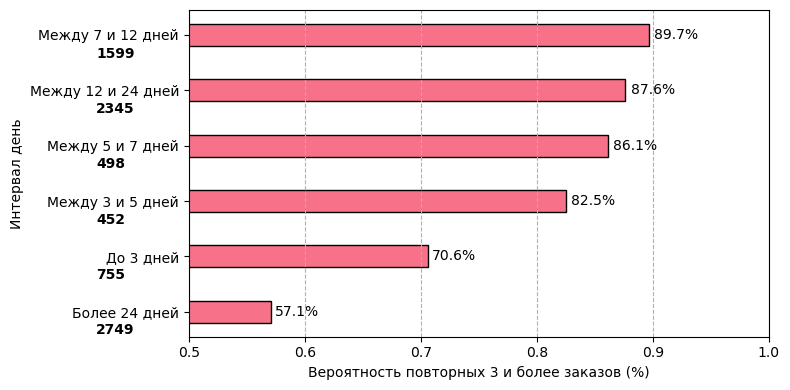

In [215]:
# Визуализация
ax = rate_cat_day['rate'].plot(kind='barh',
                         figsize=(8, 4),
                         width=0.4,
                         edgecolor='k')

plt.xlim([0.5, 1])

plt.ylabel('Интервал день')
plt.xlabel('Вероятность повторных 3 и более заказов (%)')

for i, val in enumerate(rate_cat_day['rate']):
    ax.text(val + val * 0.005,
           i,
           f"{val * 100:.1f}%",
           va='center')
    
for i, val in enumerate(rate_cat_day['users']):
    ax.text(0.42,
           i-0.41,
           val,
           fontweight='bold')
    
plt.yticks(ticks=[0, 1, 2, 3, 4, 5],
          labels=['Более 24 дней', 'До 3 дней', 'Между 3 и 5 дней', 
                  'Между 5 и 7 дней', 'Между 12 и 24 дней', 'Между 7 и 12 дней'])

plt.grid(axis='x', ls='--')
plt.tight_layout()

**Краткий вывод:**<br>
Интервал первым и последний заказом, между `3 — 24 дней` верятность больше `(серднем 86%)` среди пользователей на повторную покупку. При более короких или более длительный интервал, верятность повторных покупок снижается. 

---

### 4.4. Корреляционный анализ количества покупок и признаков пользователя
#### 4.4.1 корреляционный анализ 

In [216]:
phik_matr = phik_matrix(df=agg_users[['first_order_dt', 'last_order_dt', 'first_order_device',
       'first_order_region', 'first_order_service', 'first_order_event_type',
       'cnt_orders', 'total_revenue', 'total_tickets', 'avg_rev_per_order',
       'avg_cnt_tick_per_ord', 'avg_dt_order']],
           interval_cols=['cnt_orders',
                         'total_revenue',
                         'total_tickets',
                         'avg_rev_per_order',
                         'avg_cnt_tick_per_ord'])

phik_matr

C:\Users\Zhalgas\anaconda3\envs\requirements3\lib\site-packages\phik\data_quality.py:62: UserWarning: The number of unique values of variable avg_dt_order is large: 1104. Are you sure this is not an interval variable? Analysis for pairs of variables including avg_dt_order can be slow.
  col, df[col].nunique()


,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order
first_order_dt,1.000000,0.999020,0.104890,0.463570,0.292767,0.250571,0.346252,0.277153,0.322864,0.185075,0.154393,0.578694
last_order_dt,0.999020,1.000000,0.083273,0.363026,0.242405,0.157221,0.348804,0.198174,0.330124,0.202869,0.172120,0.000000
first_order_device,0.104890,0.083273,1.000000,0.112009,0.078278,0.061442,0.044561,0.054626,0.058630,0.074275,0.060051,0.071692
first_order_region,0.463570,0.363026,0.112009,1.000000,0.694002,0.500706,0.000000,0.000000,0.000000,0.367057,0.169965,0.000000
first_order_service,0.292767,0.242405,0.078278,0.694002,1.000000,0.587645,0.000000,0.133255,0.128279,0.394473,0.061916,0.000000
first_order_event_type,0.250571,0.157221,0.061442,0.500706,0.587645,1.000000,0.024990,0.107068,0.017867,0.339716,0.097248,0.000000
cnt_orders,0.346252,0.348804,0.044561,0.000000,0.000000,0.024990,1.000000,0.694240,0.884371,0.241364,0.287580,0.970831
total_revenue,0.277153,0.198174,0.054626,0.000000,0.133255,0.107068,0.694240,1.000000,0.800787,0.432743,0.199234,0.927856
total_tickets,0.322864,0.330124,0.058630,0.000000,0.128279,0.017867,0.884371,0.800787,1.000000,0.234867,0.258632,0.926392
avg_rev_per_order,0.185075,0.202869,0.074275,0.367057,0.394473,0.339716,0.241364,0.432743,0.234867,1.000000,0.450893,0.000000


In [217]:
plot_phik = phik_matr.loc[phik_matr.index != 'cnt_orders'][['cnt_orders']].sort_values(by='cnt_orders',
                                                                                      ascending=False)

<AxesSubplot:>

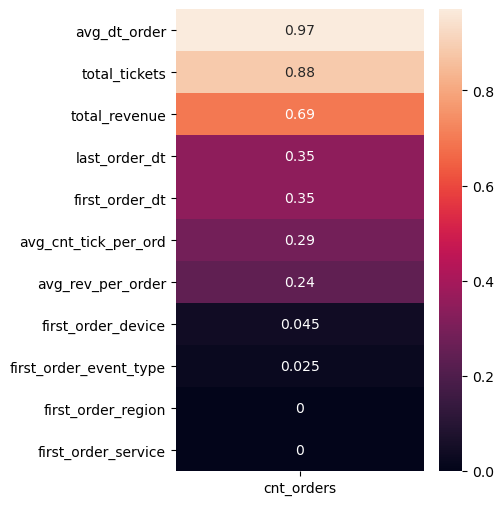

In [218]:
plt.figure(figsize=(4, 6))
sns.heatmap(data=plot_phik,
           annot=True,
           linecolor='k')

Попробуем сегментировать `cnt_orders`, и проверить будет ли разница.

In [219]:
agg_users['segment_order'] = pd.cut(x=agg_users['cnt_orders'],
                                    bins=[0, 2, 4, agg_users['cnt_orders'].max()],
                                   labels=['1_ord', '2_4_ord', '5+ord'])
agg_users.head()

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_order_service,first_order_event_type,cnt_orders,total_revenue,total_tickets,avg_rev_per_order,avg_cnt_tick_per_ord,avg_dt_order,is_two,is_five,segment_order
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.0,1521.939941,4.000000,0 days 00:00:00,False,False,1_ord
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,1548.020020,6.0,774.010010,3.000000,37 days 12:00:00,True,False,1_ord
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,2301.640137,8.0,767.213379,2.666667,34 days 00:00:00,True,False,2_4_ord
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.0,917.830017,4.000000,0 days 00:00:00,False,False,1_ord
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,122.619995,3.0,61.309998,1.500000,8 days 00:00:00,True,False,1_ord


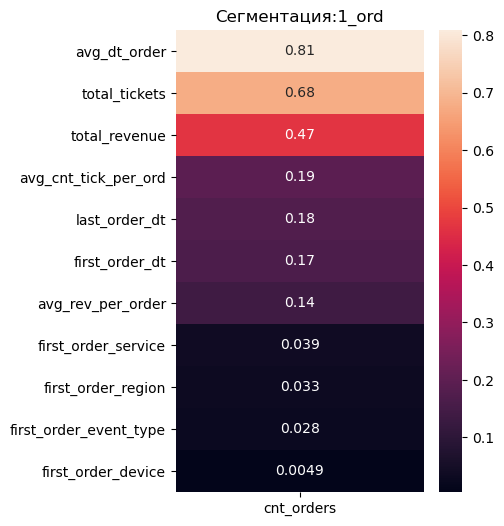

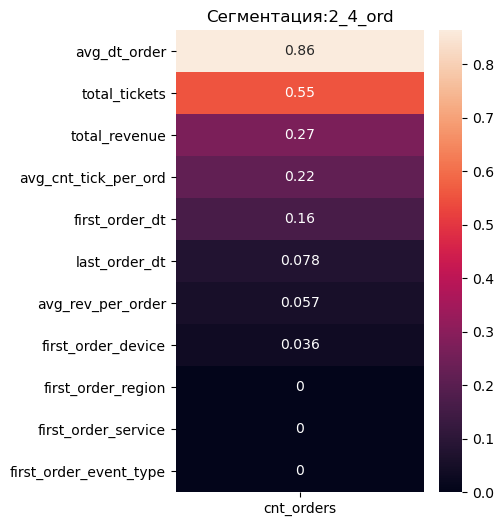

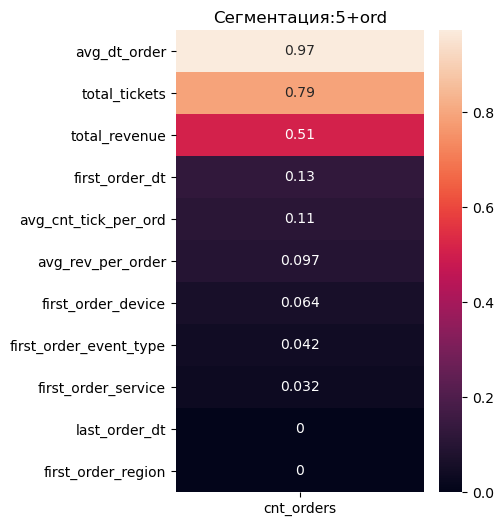

In [220]:
for i in agg_users['segment_order'].unique():
    temp = agg_users[agg_users['segment_order'] == i]
    
    res = phik_matrix(temp[['first_order_dt', 'last_order_dt', 'first_order_device',
       'first_order_region', 'first_order_service', 'first_order_event_type',
       'cnt_orders', 'total_revenue', 'total_tickets', 'avg_rev_per_order',
       'avg_cnt_tick_per_ord', 'avg_dt_order']],
           interval_cols=['cnt_orders',
                         'total_revenue',
                         'total_tickets',
                         'avg_rev_per_order',
                         'avg_cnt_tick_per_ord'])
    
    res = res.loc[res.index != 'cnt_orders'][['cnt_orders']].sort_values(by='cnt_orders', ascending=False)
    
    plt.figure(figsize=(4, 6))
    sns.heatmap(data=res,
               annot=True)
    plt.title(f"Сегментация:{i}")
    plt.show()

**Краткий вывод:** <br>
По всем результатом показал столбцы: `avg_dt_order, total_tickets` и `total_revenue` сильно связано с столбцом `cnt_order`. Так же есть слабые признаки `first_order_event_type, first_order_device first_order_dt` и `last_order_dt`.

---

# 5. Общие выводы и рекомендации

### 1. Информация о данных:
- Данные по выручке были приведены к единой валюте — `рублей`;
- Не встретились `дубликаты`;
- Общий количество пользователей — `21.848` из них только `60%` повторно купили заказы;
- **Общая выручка** — `148,603,170 рублей`.
- **Средняя выручка** — `516` рублей;
- **Среднее количество заказов** — `13`, медиана — `2`;
- Отфильтровали данные по количество заказов, так как встретились аномальные цирфы. `90%` данные до `15` заказов, `95%` данные до `32` заказов и между `95% и 100%` данные встретились до `10175` количество заказов. Так мы решили удалит `10%` данные `выше 90%` процентиль, это `2134` строка;
- После фильтрация остались `19.714` пользователей;
- После фильтрация среднее количество покупка билетов — `3`. Клиенты часто купять билеты между диапазоне `1 - 4`;
- Общий количество мероприятия — `22364`.
    


### 2. Основные результаты анализа:
- Пользователей 1-у покупку больше купили на `концерт` — 8687 `(44%)` и `другое` — 4952 `(25%)` и `театр` — 3834 `(19%)`, больше `80%` купили через устройство `телефон`. Топ регионы по покупку `1-й` билет: `Каменесвкий регион` — 6409 `(35%)`, `Североярская область` — 3396 `(19%)` и `Широковская область` — 1139 `(6%)`. Операторы, у кого больше клиенты с `1-ый покупкой`: `Билеты без проблем` — `4697` (24%), `Мой билет` — `2706` (14%), `Лови билет` — `2575` (13%), `Билеты в руки` — `2297` (12%) и `Облачко` — `2015` (10%);
- `11974` пользователи есть, из них `57%` (11349) купили заказы `2 и более раз`. `21%` (4203) пользователей `5 и более раз` купили билеты.
<br><br>
- **Заказы 2 и более раз:**
    - Регион: `Каменевский регион` — 3745 `(19%)`, `Североярская область` — 2033 `(10%)` и `Широковская область` — 705 `(4%)`, в этом регионе пользователи приобрели заказ `2 и более раз`;
    - Операторы: `Билеты без проблем` — 2645 `(13%)`, `Мой билет` — 1544 `(8%)` и `Лови билет!` — 1481 `(7%)`, эти операторы нашли клиенты, которые купили заказы 2 и больше раз;
    - Мериоприятия: `Концерты` — 5022 `(25%)`, `другое` — 2775 `(14%)` и `театр` — 2282 `(12%)`, клиенты на этих меропритиях приобрели более 2 заказы. 
- **Заказы 5 и более раз:**
    - Регион: `Каменевский регион` — 1446 `(7%)`, `Североярская область` — 766 `(4%)` и `Широковская область` — 255 `(1%)`, клиенты в этом регионе чаще купили `5 и более` заказы;
    - Операторы: `Билеты без проблем` — 1016 `(5%)`, `Мой билет` — 576 `(3%)` и `Лови билет!` — 550 `(3%)`, у этих операторв больше клиенты с 5 и более заказами;
    - Мериоприятия: `Концерты` — 1836 `(9%)`, `другое` — 1079 `(5%)` и `театр` — 848 `(4%)`, клиенты купили билеты на этих меропритиях более 5 заказы.
<br><br>        
- **1 заказ:**
    - Средняя выручка находиться в диапазоне между `500-550 рублей`;
    - Частота средняя сумма больше находиться между от `50-1000 рублей`.

- **2 или более заказы:**
    - Средняя выручка находиться в диапазоне между `500-550 рублей`;
    - Частота средняя сумма больше находиться между `50-1500 рублей`.
- Kлиенты с `1 заказом` больше рассмотривают покупку билеты средняя сумма до `300рублей`, с `2 или более` заказами  чаще покупают билеты средняя сумма до `1000рублей`.
   <br><br>
-   **Все Пользователи:**
    - `значение:` **от 2 до 3 билетов** — 8015 `(41%)`, пользователи купили среднем билеты между `2 и 3`;
    - `значение:` **от 3 до 5 билетов** — 8644 `(44%)`, пользователи купили среднем билеты между `3 и 5`;
    - `аномалия:` **от 5 и более заказов** — 661 `(3.4%)`, сегмент находиться очень низко сравнивая с другими, это цифр клиенты, которые больше купили в среднем `5 или более билетов`.

- **Пользователи с повторными заказми:**
    - `значение:` **от 2 до 3 билетов** — 5505 `(28%)`, пользователи с `2 и более` зкакзами, купили среднем билеты между `2 и 3`;
    - `значение:` **от 3 до 5 билетов** — 4504 `(23%)`, пользователи с `2 и более` зкакзами, купили среднем билеты между `3 и 5`;
    - `аномалия:` **от 5 и более заказов** — 124 `(0.6%)`, очень низкий доля чем других. Клиенты очень мало сранивая с другими сегментами, которые повторно возвращаются и купить в среднеи `5 и более билетов`. 
<br><br>

- Средний интервал покупка повторных заказов — 18 день;
-  День неделя `1-ая покупка` не влияет на возврат клиентов. Все пользователи включая с `1-покупками` в день между диапазоне `2500-3000`, это `14%` пользователи от общего. Пользователей с `2 и более покупками` находится 1400-1700 `(8%)`;
- `26%` пользователей, которые совершили `2 и более заказы` совершили в `1 день`, и не возвращались на сервсис. Интервал `1-м` и `последним заказом` больше находится `от 0 до 40 дней`;
- Средний интервал совершившие 2–4 заказа: 21.3 день;
- Средний интервал совершившие 5 и более заказов: 12.1 день;
- Интервал первым и последний заказом, между `3 — 24 дней` верятность больше `(серднем 86%)` среди пользователей на повторную покупку. При более короких или более длительный интервал, верятность повторных покупок снижается; 
- столбцы: `avg_dt_order, total_tickets` и `total_revenue` сильно связано с столбцом `cnt_order`. Так же есть слабые признаки `first_order_event_type, first_order_device first_order_dt` и `last_order_dt`.


### 3. Рекомендации заказчику:

- **Сфокусироваться на пользователях с 2–4 заказами как на ключевом сегменте роста** 
    - Сегмент пользователей с 2–4 заказами является самым массовым среди повторных покупателей и демонстрирует:
        - стабильную частоту покупок;
        - средний интервал между заказами около 21 дня;
        - более высокий средний чек по сравнению с пользователями с 1 заказом.
- **Рекомендуется:**
    - запускать персонализированные предложения: скидки, промокоды через 15–20 дней после последнего заказа;
    - использовать напоминания о мероприятиях схожей тематики (концерты, театр).
- **Цель:** перевести часть пользователей из сегмента 2–4 заказа в сегмент 5+ заказов.
<br><br>
- **Усилить удержание пользователей с 1 заказом**
    - Пользователи с 1 заказом составляют значительную долю базы, но:
        - имеют более низкий средний чек;
        - чаще покупают билеты до 300 рублей;
        - многие не возвращаются на сервис.
- **Рекомендуется:**
    - запускать email или push в первые 3–10 дней после первой покупки;
    - предлагать простые и недорогие события, например: концерты, массовые мероприятия;
    - тестировать бонус за вторую покупку: скидка или кешбэк.
- **Цель:** повысить конверсию из 1 заказа в повторную покупку.
<br><br>
- **Работать с пользователями с 5 и более заказами как с лояльной аудиторией**
- Пользователи с 5+ заказами:
    - имеют самый короткий интервал между покупками (в среднем 12 дней);
    - чаще возвращаются без дополнительных стимулов;
- **Рекомендуется:**
    - выделить этот сегмент в отдельную группу;
    - предлагать эксклюзивные акции, ранний доступ к билетам;
    - использовать программы лояльности.
- **Цель:** удержание и увлечение выручки.
<br><br>
- **Учитывать оптимальный временной интервал повторных покупок**
    - Наиболее высокая вероятность повторной покупки наблюдается при интервале между первым и последним заказом от 3 до 24 дней (в среднем 86%).
    - При более коротких или более длительных интервалах вероятность повторных покупок снижается.
- **Рекомендуется:**
    - выстраивать коммуникации с пользователями именно в этом временном окне;
    - использовать триггерные рассылки, основанные на дате последнего заказа.

**Итоговая рекомендация:**<br>
Основной потенциал роста выручки сервиса заключается не в привлечении новых пользователей, а в увеличении частоты повторных покупок среди существующей аудитории, особенно пользователей с 2–4 заказами. Грамотная сегментация, персонализированные предложения и работа с временными интервалами покупок позволят повысить удержание клиентов и общий LTV.

`p.s: В конце на рекомендации заказчику захотелось написать как реальный аналитик :), загуглил и использовал ИИ, чтобы чуть выглядил как настоящий =).`